In [1160]:
# Import all necessary libraries after kernel reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Run modeling setup after reset
import pandas as pd
import numpy as np
import shap
shap.initjs()

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from scipy.optimize import minimize
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
    

import warnings
warnings.filterwarnings('ignore')

In [1161]:
try:
    # Attempt to load the dataset from CSV file
    df = pd.read_csv('conjura_mmm_data.csv', delimiter=',', encoding='utf-8')
    print("It was successfully loaded.")
except Exception as e:
    # Print failure message if loading fails
    print("Failed to load the dataset.")
    print(f"Error: {e}")

It was successfully loaded.


# ----EDA and Preprocessing

In [1163]:
# Initial shape before cleaning
initial_shape = df.shape

In [1164]:
initial_shape

(132759, 50)

In [1165]:
# checking for duplicates
df.duplicated().any()

False

In [1166]:
initial_info = df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132759 entries, 0 to 132758
Data columns (total 50 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   MMM_TIMESERIES_ID                    132759 non-null  object 
 1   ORGANISATION_ID                      132759 non-null  object 
 2   ORGANISATION_VERTICAL                124649 non-null  object 
 3   ORGANISATION_SUBVERTICAL             124649 non-null  object 
 4   ORGANISATION_MARKETING_SOURCES       132759 non-null  object 
 5   ORGANISATION_PRIMARY_TERRITORY_NAME  132759 non-null  object 
 6   TERRITORY_NAME                       132759 non-null  object 
 7   DATE_DAY                             132759 non-null  object 
 8   CURRENCY_CODE                        132759 non-null  object 
 9   FIRST_PURCHASES                      132759 non-null  int64  
 10  FIRST_PURCHASES_UNITS                132759 non-null  int64  
 11  FIRST_PURCHAS

In [1167]:
df.head()

MMM_TIMESERIES_ID                   ORGANISATION_ID  \
0  596eef7c71f933d820d0e485935d0e8f  04769dac8b828ec7a85676d9e2bffe6f   
1  596eef7c71f933d820d0e485935d0e8f  04769dac8b828ec7a85676d9e2bffe6f   
2  596eef7c71f933d820d0e485935d0e8f  04769dac8b828ec7a85676d9e2bffe6f   
3  596eef7c71f933d820d0e485935d0e8f  04769dac8b828ec7a85676d9e2bffe6f   
4  596eef7c71f933d820d0e485935d0e8f  04769dac8b828ec7a85676d9e2bffe6f   

  ORGANISATION_VERTICAL ORGANISATION_SUBVERTICAL  \
0      Beauty & Fitness                Hair Care   
1      Beauty & Fitness                Hair Care   
2      Beauty & Fitness                Hair Care   
3      Beauty & Fitness                Hair Care   
4      Beauty & Fitness                Hair Care   

  ORGANISATION_MARKETING_SOURCES ORGANISATION_PRIMARY_TERRITORY_NAME  \
0                   Google, Meta                                  US   
1                   Google, Meta                                  US   
2                   Google, Meta                                  US   
3                   Google, Meta                                  US   
4                   Google, Meta                                  US   

    TERRITORY_NAME    DATE_DAY CURRENCY_CODE  FIRST_PURCHASES  ...  \
0  All Territories  2022-07-29           USD               22  ...   
1  All Territories  2022-07-30           USD               14  ...   
2  All Territories  2022-07-31           USD               31  ...   
3  All Territories  2022-08-01           USD               18  ...   
4  All Territories  2022-08-02           USD               23  ...   

   META_FACEBOOK_IMPRESSIONS  META_INSTAGRAM_IMPRESSIONS  \
0                    18997.0                         NaN   
1                    20188.0                         NaN   
2                    24718.0                         NaN   
3                    25076.0                         NaN   
4                    22688.0                         NaN   

   META_OTHER_IMPRESSIONS  TIKTOK_IMPRESSIONS  DIRECT_CLICKS  \
0                     NaN                 NaN          139.0   
1                     NaN                 NaN          209.0   
2                     NaN                 NaN          262.0   
3                     NaN                 NaN          247.0   
4                     NaN                 NaN          255.0   

   BRANDED_SEARCH_CLICKS  ORGANIC_SEARCH_CLICKS  EMAIL_CLICKS  \
0                    NaN                  300.0           1.0   
1                    NaN                  442.0           8.0   
2                    NaN                  427.0         631.0   
3                    NaN                  400.0         117.0   
4                    NaN                  425.0          37.0   

   REFERRAL_CLICKS  ALL_OTHER_CLICKS  
0             61.0              40.0  
1            110.0              62.0  
2            108.0              65.0  
3            125.0              68.0  
4            146.0              65.0  

[5 rows x 50 columns]

In [1168]:
# Convert date column
df['DATE_DAY'] = pd.to_datetime(df['DATE_DAY'])

###  -------------- Raw Dataframe

In [1170]:
df.shape

(132759, 50)

In [1171]:
#Extract numerical and categorical features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

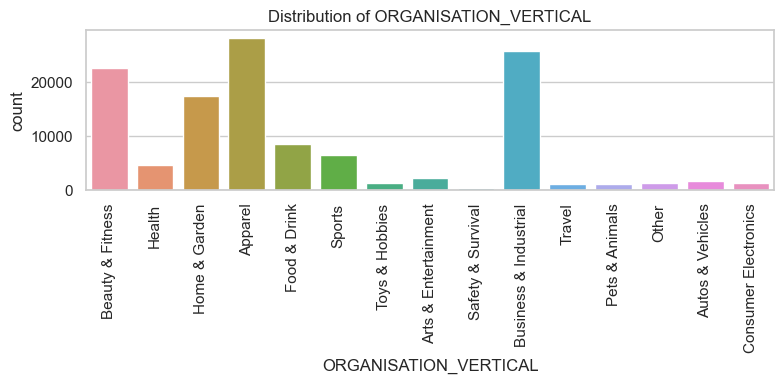

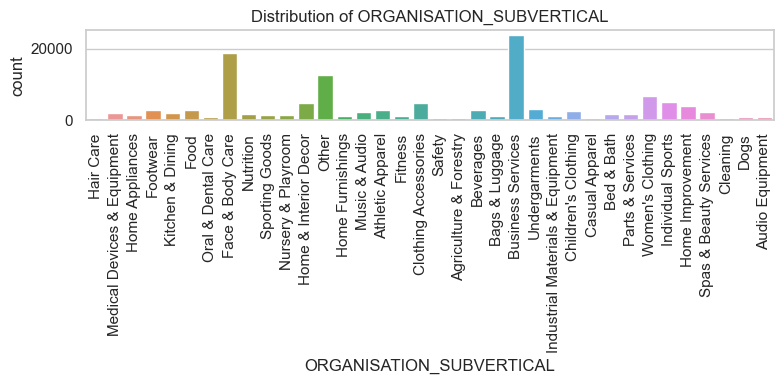

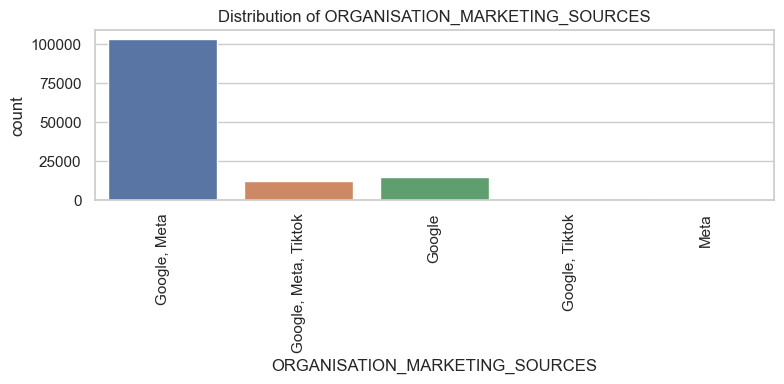

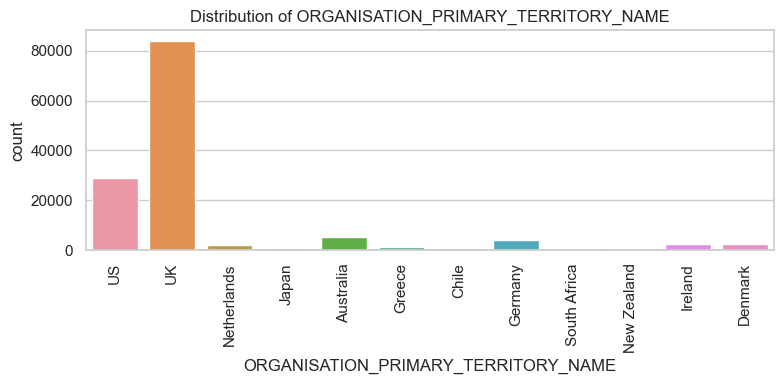

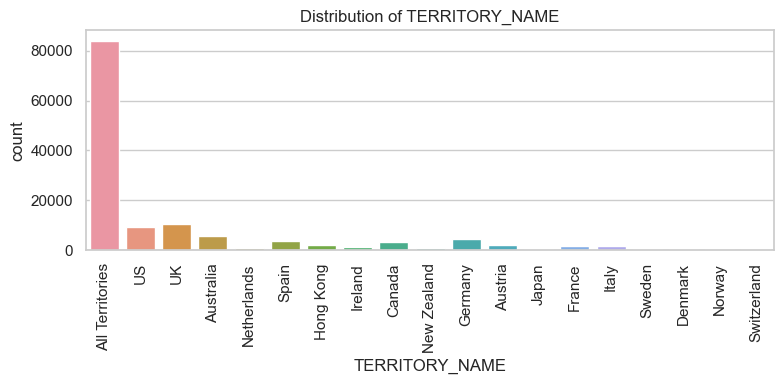

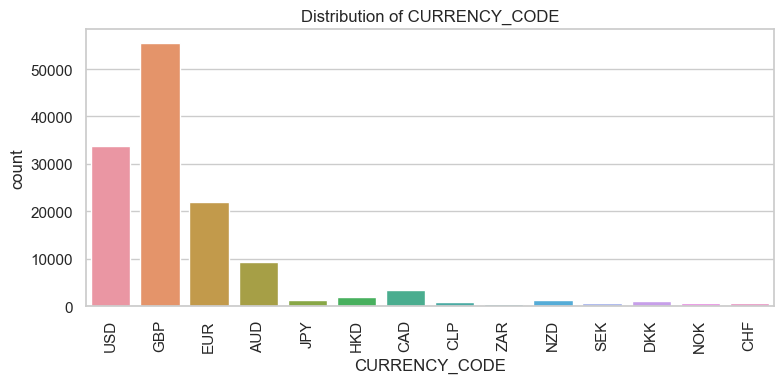

In [1172]:
#Number of unique elements in each categorical variable
unique_counts = df[categorical_features].nunique()

#Visualize distributions (excluding first two IDs for readability)
uniq_ele = df[categorical_features].iloc[:, 2:].columns

# Store plots to review later
for x in uniq_ele:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=x, data=df)
    plt.xticks(rotation=90)
    plt.title(f'Distribution of {x}')
    plt.tight_layout()
    plt.show()

In [1173]:
# Create revenue feature
df['revenue'] = (df['ALL_PURCHASES_ORIGINAL_PRICE'] * df['ALL_PURCHASES_UNITS']) - df['FIRST_PURCHASES_GROSS_DISCOUNT']

### -----Confirmed addition feature "Revenue" for target variable

In [1175]:
df.shape

(132759, 51)

In [1176]:
# Step 8: Find top 5 ORGANISATION_IDs by frequency
top_orgs = df['ORGANISATION_ID'].value_counts().nlargest(5)
# Select the top 1 org ID for focused analysis
top_org_id = top_orgs.index[0]

# Filter dataset
df1 = df[df['ORGANISATION_ID'] == top_org_id].copy()

### ---- Picking most frequent organisation (country) by selecting most frequent organisation ID

In [1178]:
df1.shape

(16228, 51)

##  ----------Unique timeseries per territory

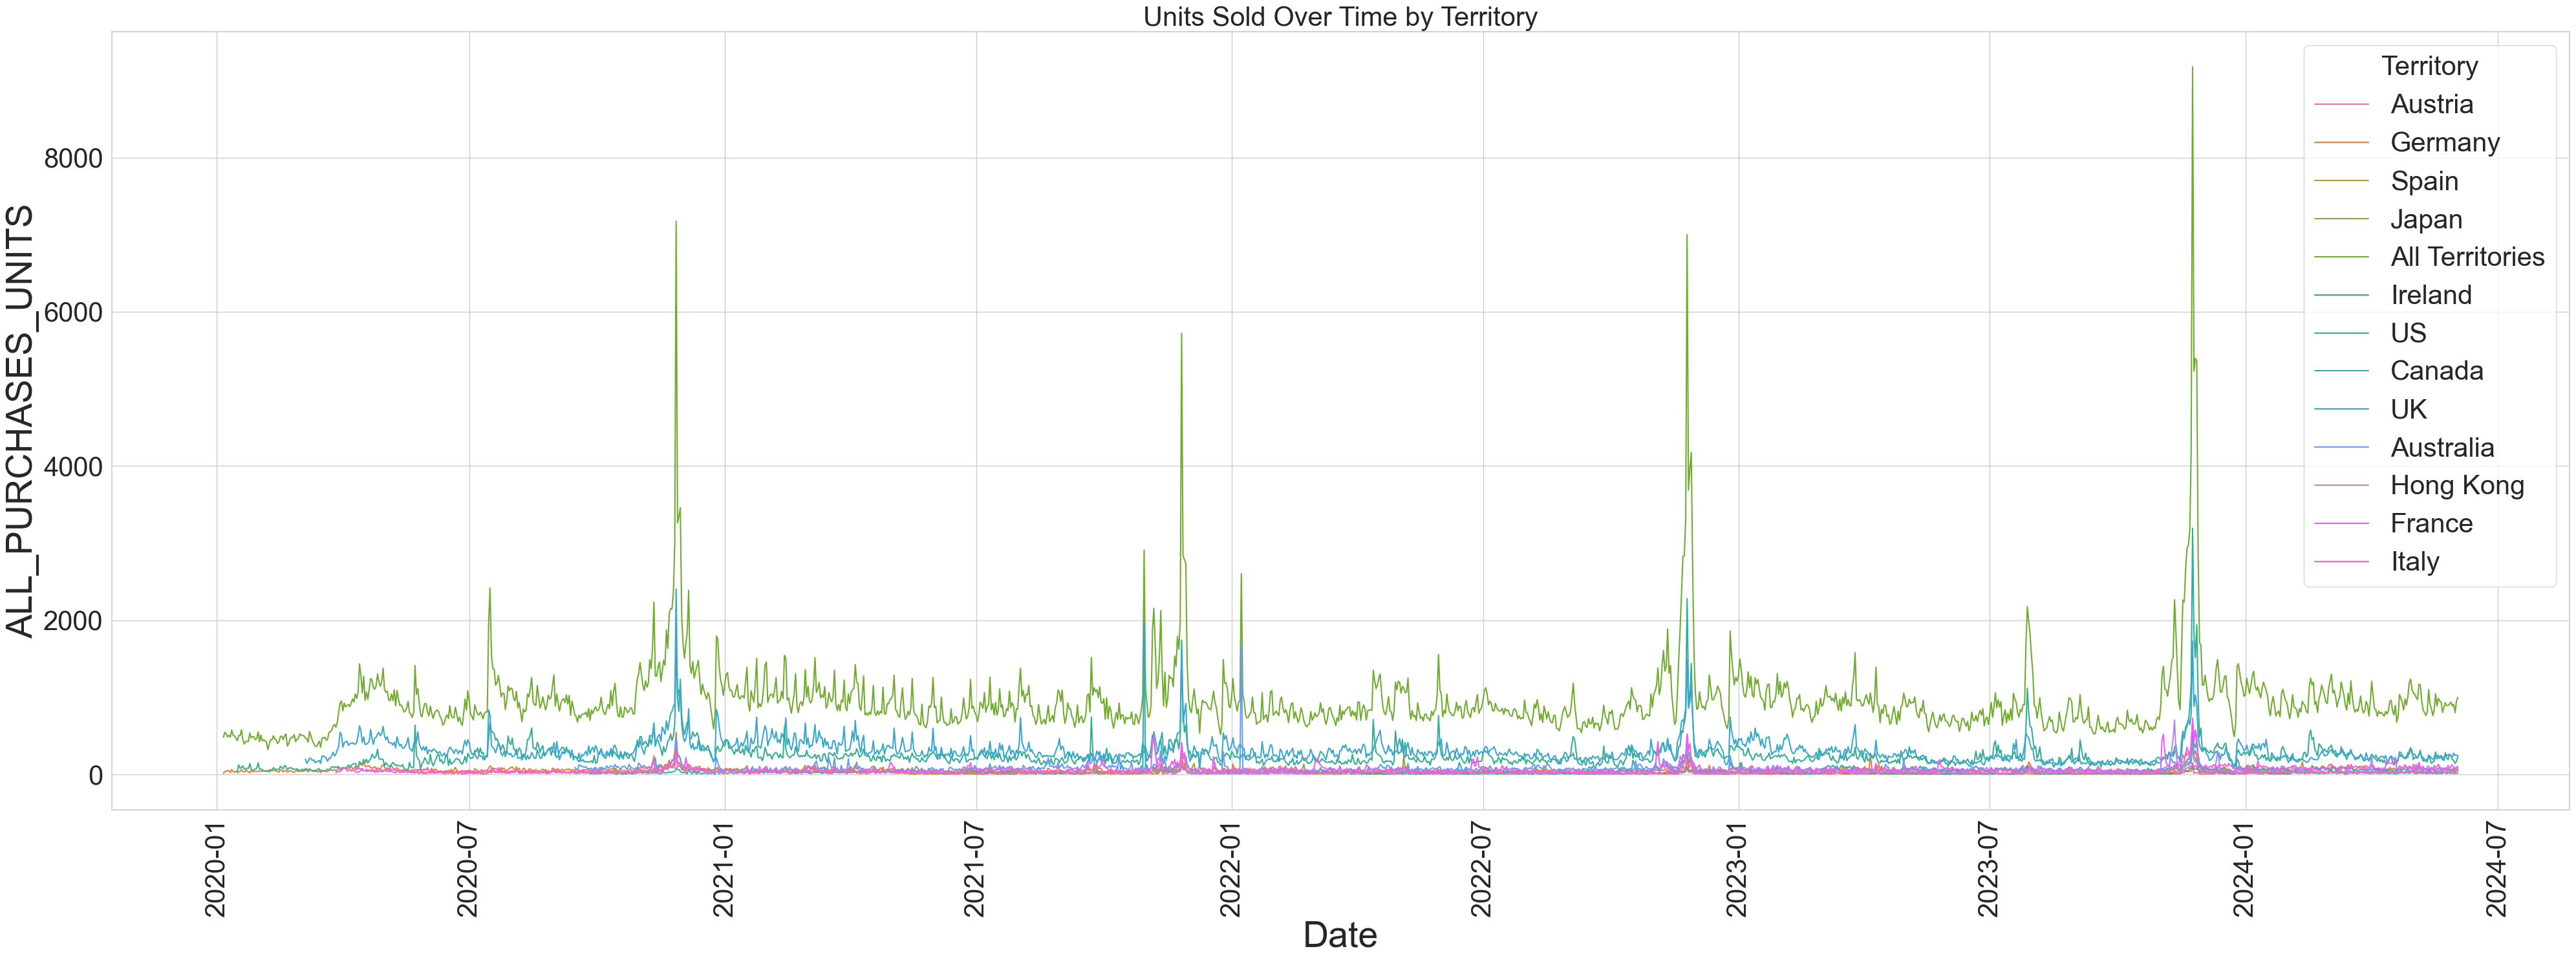

In [1180]:
# Step 11: Unique timeseries per territory
unique_series_by_territory = df1[df1['TERRITORY_NAME'] == 'Germany']['MMM_TIMESERIES_ID'].unique()

# Step 12: Time series plot by territory
plt.figure(figsize=(40, 15))
sns.lineplot(x='DATE_DAY', y='ALL_PURCHASES_UNITS', data=df1, hue='TERRITORY_NAME')

# Bigger axis labels
plt.xlabel('Date', fontsize=40)
plt.ylabel('ALL_PURCHASES_UNITS', fontsize=40)

# Bigger tick labels
plt.xticks(rotation=90, fontsize=30)
plt.yticks(fontsize=30)

# Bigger legend
plt.legend(title='Territory', title_fontsize=30, fontsize=30, loc='upper right')

# Bigger title
plt.title('Units Sold Over Time by Territory', fontsize=30)

plt.tight_layout()
plt.show()

In [1181]:
# Step 10: MMM_TIMESERIES_ID distribution
timeseries_counts = df1['MMM_TIMESERIES_ID'].value_counts()
timeseries_counts.head(), unique_series_by_territory.tolist()

(MMM_TIMESERIES_ID
 37dc412832e2dd8c5938ecbf2f4dd7fd    1610
 51c8843bddcc604ebb3fe8d638ee5a1d    1610
 9e596c450a0107c984ce52eab254dce3    1600
 ac1ed95f5069ab8003fb61aa7b5b42f1    1551
 edb2fa959b5bb803bddc33d1bd2b7ab1    1529
 Name: count, dtype: int64,
 ['37dc412832e2dd8c5938ecbf2f4dd7fd'])

###  --------Exclude 'All Territories feature' to deal with countries individualy and avoid redundancy

In [1183]:
#Exclude 'All Territories'
df2 = df1[df1['TERRITORY_NAME'] == 'All Territories'].copy()

# Step 14: Print unique values for each categorical feature
unique_values_by_column = {}
for col in df2[categorical_features].columns:
    unique_values_by_column[col] = df2[col].unique().tolist()

# Step 15: Fill NA with 0 for modeling
df2.fillna(0, inplace=True)

unique_values_by_column

{'MMM_TIMESERIES_ID': ['51c8843bddcc604ebb3fe8d638ee5a1d'],
 'ORGANISATION_ID': ['ba773ebd7ec0a08f1d042187d086ccb4'],
 'ORGANISATION_VERTICAL': ['Business & Industrial'],
 'ORGANISATION_SUBVERTICAL': ['Business Services'],
 'ORGANISATION_MARKETING_SOURCES': ['Google, Meta'],
 'ORGANISATION_PRIMARY_TERRITORY_NAME': ['UK'],
 'TERRITORY_NAME': ['All Territories'],
 'CURRENCY_CODE': ['GBP']}

###  -------Break down clicks into smaller groups for clearer plots

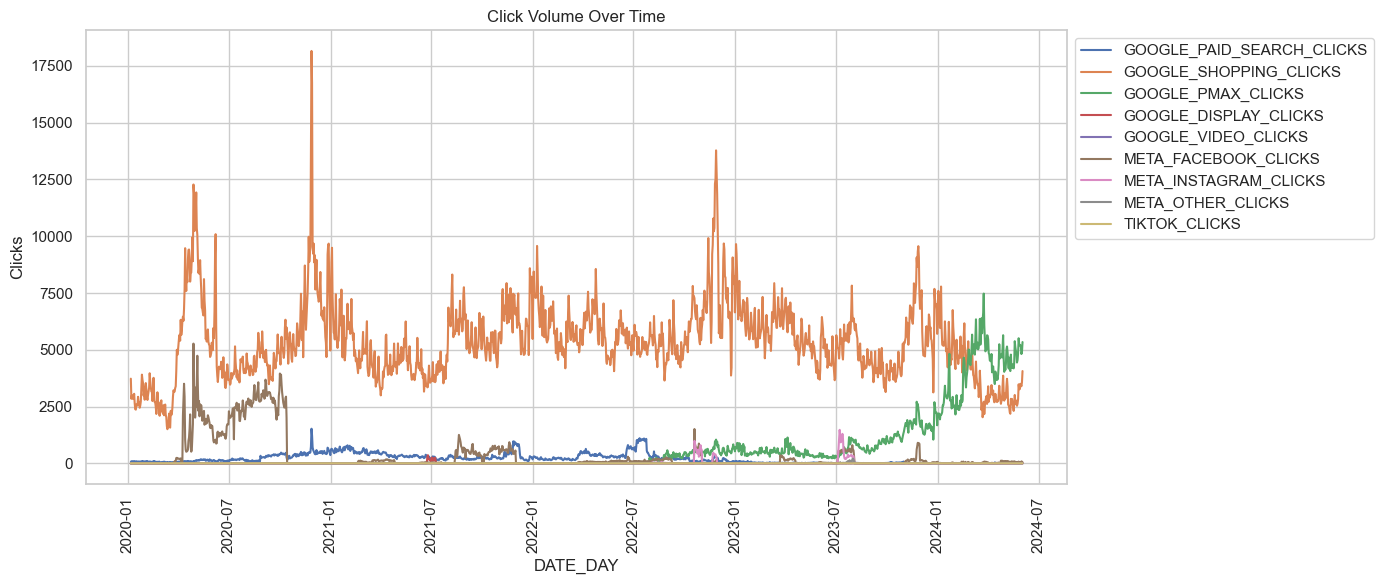

In [1185]:
# Break down clicks into smaller groups for clearer plots

clicks = [
    'GOOGLE_PAID_SEARCH_CLICKS', 'GOOGLE_SHOPPING_CLICKS', 'GOOGLE_PMAX_CLICKS',
    'GOOGLE_DISPLAY_CLICKS', 'GOOGLE_VIDEO_CLICKS', 'META_FACEBOOK_CLICKS',
    'META_INSTAGRAM_CLICKS', 'META_OTHER_CLICKS', 'TIKTOK_CLICKS'
]

plt.figure(figsize=(14, 6))
for col in clicks:
    sns.lineplot(x='DATE_DAY', y=col, data=df2, label=col)

plt.title('Click Volume Over Time')
plt.xticks(rotation=90)
plt.ylabel('Clicks')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

### ------Plot impressions data

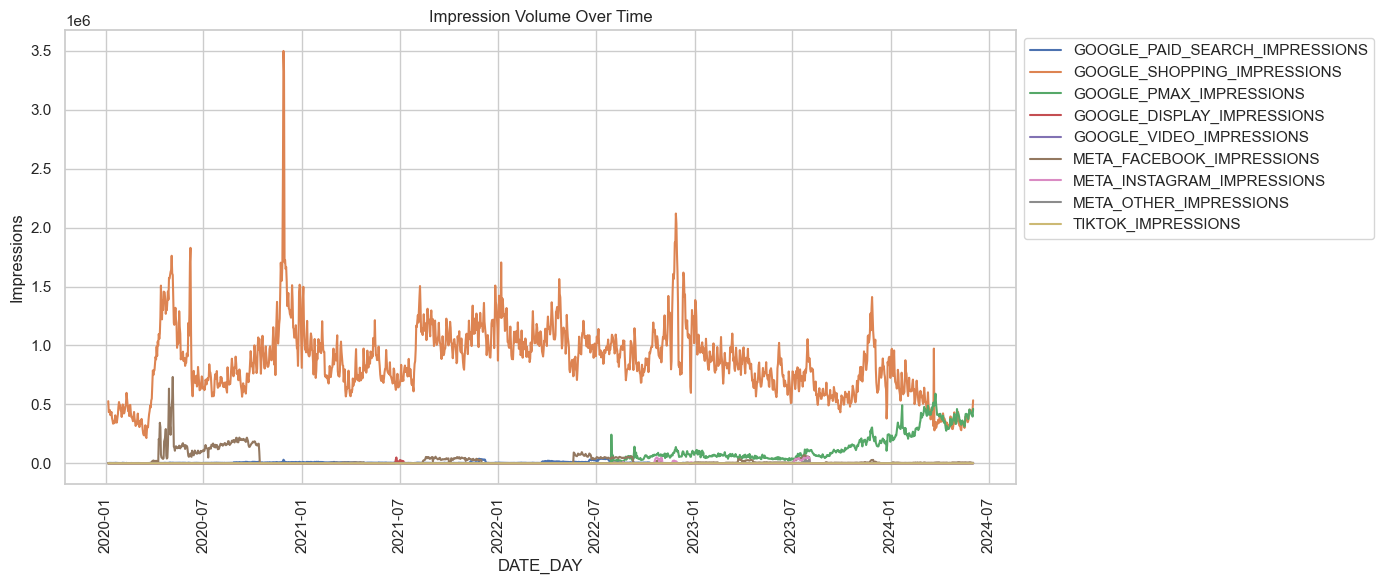

In [1187]:
# Step 19: Plot impressions data
impressions = [
    'GOOGLE_PAID_SEARCH_IMPRESSIONS', 'GOOGLE_SHOPPING_IMPRESSIONS',
    'GOOGLE_PMAX_IMPRESSIONS', 'GOOGLE_DISPLAY_IMPRESSIONS',
    'GOOGLE_VIDEO_IMPRESSIONS', 'META_FACEBOOK_IMPRESSIONS',
    'META_INSTAGRAM_IMPRESSIONS', 'META_OTHER_IMPRESSIONS',
    'TIKTOK_IMPRESSIONS'
]

plt.figure(figsize=(14, 6))
for col in impressions:
    sns.lineplot(x='DATE_DAY', y=col, data=df2, label=col)

plt.title('Impression Volume Over Time')
plt.xticks(rotation=90)
plt.ylabel('Impressions')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

###  --------Plot additional control variables

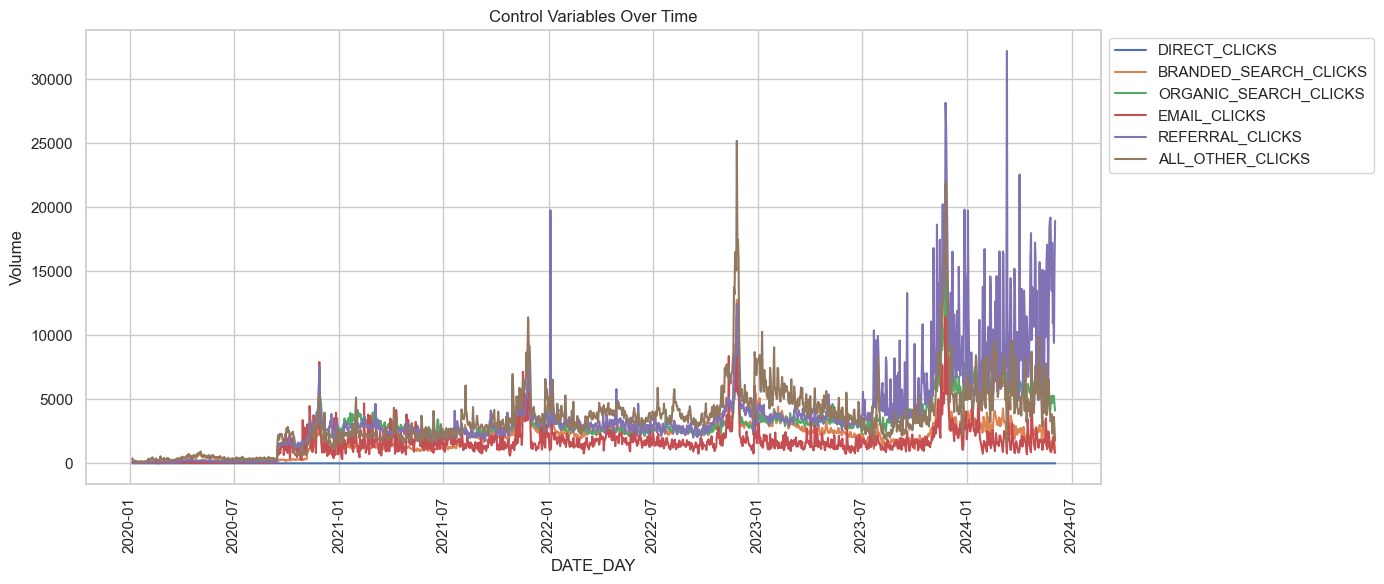

In [1189]:
# Step 20: Plot additional control variables
controls = [
    'DIRECT_CLICKS', 'BRANDED_SEARCH_CLICKS', 'ORGANIC_SEARCH_CLICKS',
    'EMAIL_CLICKS', 'REFERRAL_CLICKS', 'ALL_OTHER_CLICKS'
]

plt.figure(figsize=(14, 6))
for col in controls:
    sns.lineplot(x='DATE_DAY', y=col, data=df2, label=col)

plt.title('Control Variables Over Time')
plt.xticks(rotation=90)
plt.ylabel('Volume')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

###  -------Break down spends into smaller groups for clearer plots

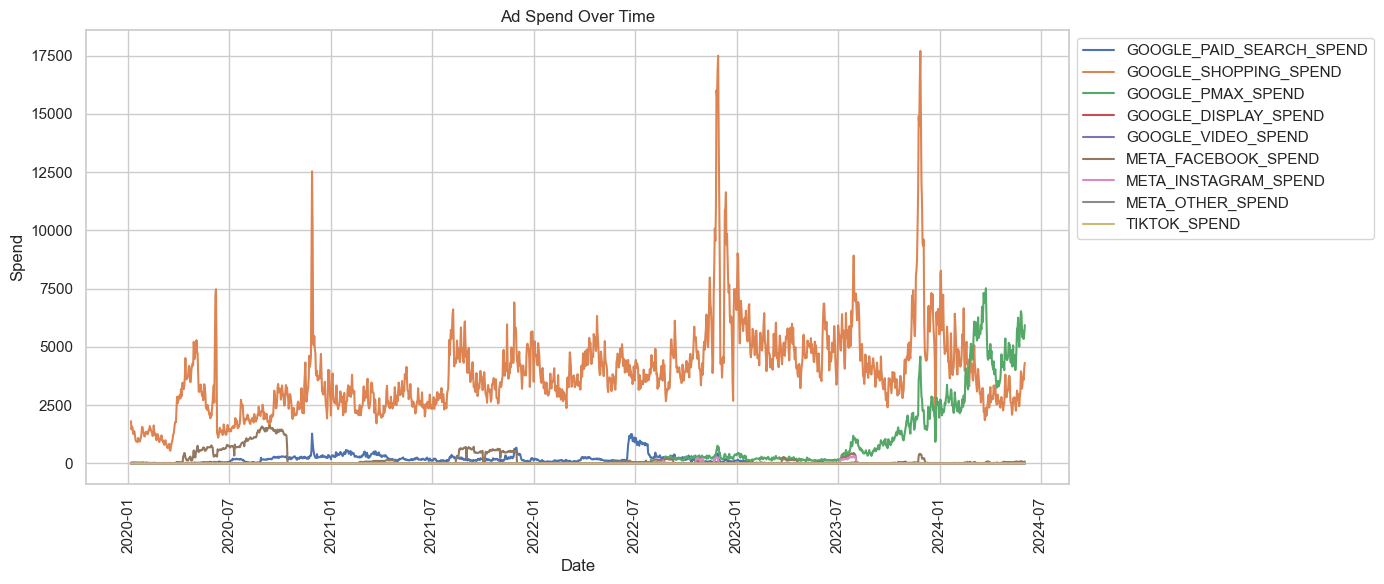

In [1191]:
# Step 18: Break down spends into smaller groups for clearer plots

spends = [
    'GOOGLE_PAID_SEARCH_SPEND', 'GOOGLE_SHOPPING_SPEND', 'GOOGLE_PMAX_SPEND',
    'GOOGLE_DISPLAY_SPEND', 'GOOGLE_VIDEO_SPEND', 'META_FACEBOOK_SPEND',
    'META_INSTAGRAM_SPEND', 'META_OTHER_SPEND', 'TIKTOK_SPEND'
]

plt.figure(figsize=(14, 6))
for col in spends:
    sns.lineplot(x='DATE_DAY', y=col, data=df2, label=col)

plt.title('Ad Spend Over Time')
plt.xticks(rotation=90)
plt.ylabel('Spend')
plt.xlabel('Date')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

###  -------Droping columns with more than 80% nulls from the full Dataframe "df"

In [1193]:
# Identify columns with more than 80% nulls
dropped_cols = df.columns[df.isnull().mean() >= 0.8].tolist()

# Print the dropped columns
print("Dropped columns due to >80% nulls:")
for col in dropped_cols:
    print(f"- {col}")

# Then drop them (if not already done)
df = df.drop(columns=dropped_cols)

Dropped columns due to >80% nulls:
- GOOGLE_DISPLAY_SPEND
- GOOGLE_VIDEO_SPEND
- META_OTHER_SPEND
- TIKTOK_SPEND
- GOOGLE_DISPLAY_CLICKS
- GOOGLE_VIDEO_CLICKS
- META_OTHER_CLICKS
- TIKTOK_CLICKS
- GOOGLE_DISPLAY_IMPRESSIONS
- GOOGLE_VIDEO_IMPRESSIONS
- META_OTHER_IMPRESSIONS
- TIKTOK_IMPRESSIONS


### --------- Fill remaining nulls with 0

In [1195]:
# Fill remaining nulls with 0
df.fillna(0, inplace=True)

In [1196]:
# Dataset description
description = df.describe()

In [1197]:
description

DATE_DAY  FIRST_PURCHASES  FIRST_PURCHASES_UNITS  \
count                         132759    132759.000000           1.327590e+05   
mean   2022-08-19 14:18:24.575961088        83.857599           5.193310e+02   
min              2019-07-21 00:00:00         0.000000           0.000000e+00   
25%              2021-11-22 00:00:00        14.000000           2.400000e+01   
50%              2022-10-13 00:00:00        33.000000           6.600000e+01   
75%              2023-06-29 00:00:00        98.000000           2.000000e+02   
max              2024-06-02 00:00:00     96010.000000           1.000404e+06   
std                              NaN       345.347969           5.033012e+03   

       FIRST_PURCHASES_ORIGINAL_PRICE  FIRST_PURCHASES_GROSS_DISCOUNT  \
count                    1.327590e+05                    1.327590e+05   
mean                     6.462644e+04                    5.094456e+03   
min                      0.000000e+00                    0.000000e+00   
25%                      1.709675e+03                    4.050000e+01   
50%                      5.262000e+03                    1.950000e+02   
75%                      1.622458e+04                    8.570809e+02   
max                      7.212126e+07                    5.840348e+06   
std                      6.148369e+05                    5.541766e+04   

       ALL_PURCHASES  ALL_PURCHASES_UNITS  ALL_PURCHASES_ORIGINAL_PRICE  \
count  132759.000000         1.327590e+05                  1.327590e+05   
mean      124.536845         1.291123e+03                  1.186526e+05   
min         1.000000         1.000000e+00                  3.490000e+00   
25%        19.000000         3.400000e+01                  2.546000e+03   
50%        49.000000         1.060000e+02                  7.542000e+03   
75%       141.000000         3.130000e+02                  2.319457e+04   
max    426403.000000         1.000922e+06                  1.308895e+08   
std      1496.001905         1.291308e+04                  1.211315e+06   

       ALL_PURCHASES_GROSS_DISCOUNT  GOOGLE_PAID_SEARCH_SPEND  ...  \
count                  1.327590e+05             132759.000000  ...   
mean                   1.215327e+04                302.871654  ...   
min                    0.000000e+00                  0.000000  ...   
25%                    6.994500e+01                  0.000000  ...   
50%                    3.137500e+02                 23.780000  ...   
75%                    1.277665e+03                127.000000  ...   
max                    1.522848e+07             165661.940000  ...   
std                    1.395501e+05               2157.630213  ...   

       GOOGLE_PMAX_IMPRESSIONS  META_FACEBOOK_IMPRESSIONS  \
count             1.327590e+05               1.327590e+05   
mean              4.651241e+04               5.886442e+04   
min               0.000000e+00               0.000000e+00   
25%               0.000000e+00               0.000000e+00   
50%               0.000000e+00               5.929000e+03   
75%               3.310400e+04               4.409100e+04   
max               5.148619e+06               3.686852e+06   
std               1.262482e+05               1.511388e+05   

       META_INSTAGRAM_IMPRESSIONS  DIRECT_CLICKS  BRANDED_SEARCH_CLICKS  \
count                1.327590e+05  132759.000000          132759.000000   
mean                 1.329963e+04     431.167235             207.078654   
min                  0.000000e+00       0.000000               0.000000   
25%                  0.000000e+00       0.000000               0.000000   
50%                  0.000000e+00     127.000000              39.000000   
75%                  0.000000e+00     446.000000             175.000000   
max                  2.603035e+06   29561.000000           22974.000000   
std                  6.306408e+04     936.601416             567.595606   

       ORGANIC_SEARCH_CLICKS   EMAIL_CLICKS  REFERRAL_CLICKS  \
count          132759.000000  132759.000000    13275

In [1198]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132759 entries, 0 to 132758
Data columns (total 39 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   MMM_TIMESERIES_ID                    132759 non-null  object        
 1   ORGANISATION_ID                      132759 non-null  object        
 2   ORGANISATION_VERTICAL                132759 non-null  object        
 3   ORGANISATION_SUBVERTICAL             132759 non-null  object        
 4   ORGANISATION_MARKETING_SOURCES       132759 non-null  object        
 5   ORGANISATION_PRIMARY_TERRITORY_NAME  132759 non-null  object        
 6   TERRITORY_NAME                       132759 non-null  object        
 7   DATE_DAY                             132759 non-null  datetime64[ns]
 8   CURRENCY_CODE                        132759 non-null  object        
 9   FIRST_PURCHASES                      132759 non-null  int64         
 

In [1199]:
# Metadata
n_orgs = df['ORGANISATION_ID'].nunique()
n_territories = df['TERRITORY_NAME'].nunique()
date_range = (df['DATE_DAY'].min(), df['DATE_DAY'].max())

In [1200]:
n_orgs, n_territories

(93, 19)

In [1201]:
date_range

(Timestamp('2019-07-21 00:00:00'), Timestamp('2024-06-02 00:00:00'))

###  ----- Plot raw revenue distribution

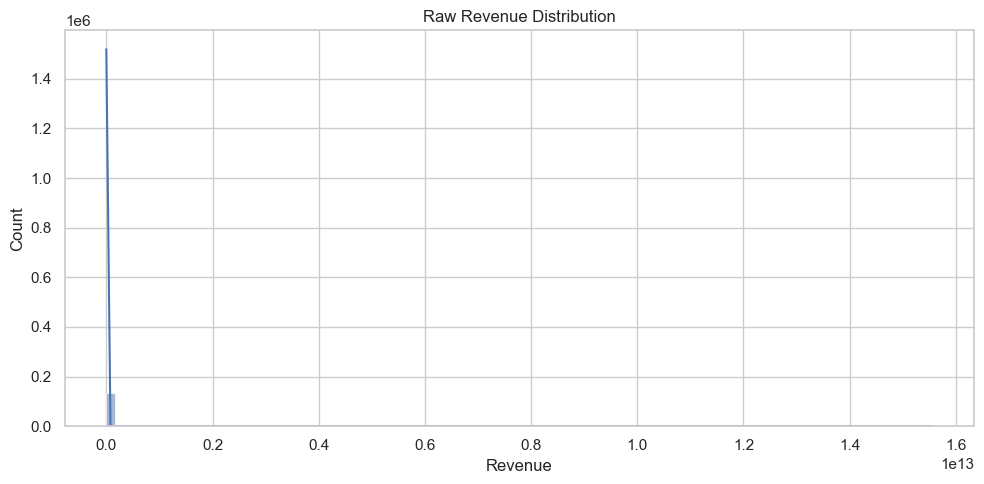

In [1203]:
# Plot raw revenue distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['revenue'], kde=True, bins=100)
plt.title('Raw Revenue Distribution')
plt.xlabel('Revenue')
plt.tight_layout()
plt.show()

###   ------Outlier Detection using IQR

In [1205]:
# Step 2: Outlier Detection using IQR
Q1 = df['revenue'].quantile(0.25)
Q3 = df['revenue'].quantile(0.75)
IQR = Q3 - Q1

In [1206]:
# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [1207]:
# Create an outlier flag
df['revenue_outlier'] = ((df['revenue'] < lower_bound) | (df['revenue'] > upper_bound))

In [1208]:
# Show count of outliers
outlier_count = df['revenue_outlier'].sum()
total_count = df.shape[0]

In [1209]:
outlier_count, total_count

(21318, 132759)

###  ------ Outliers seen on "All Territories sections"

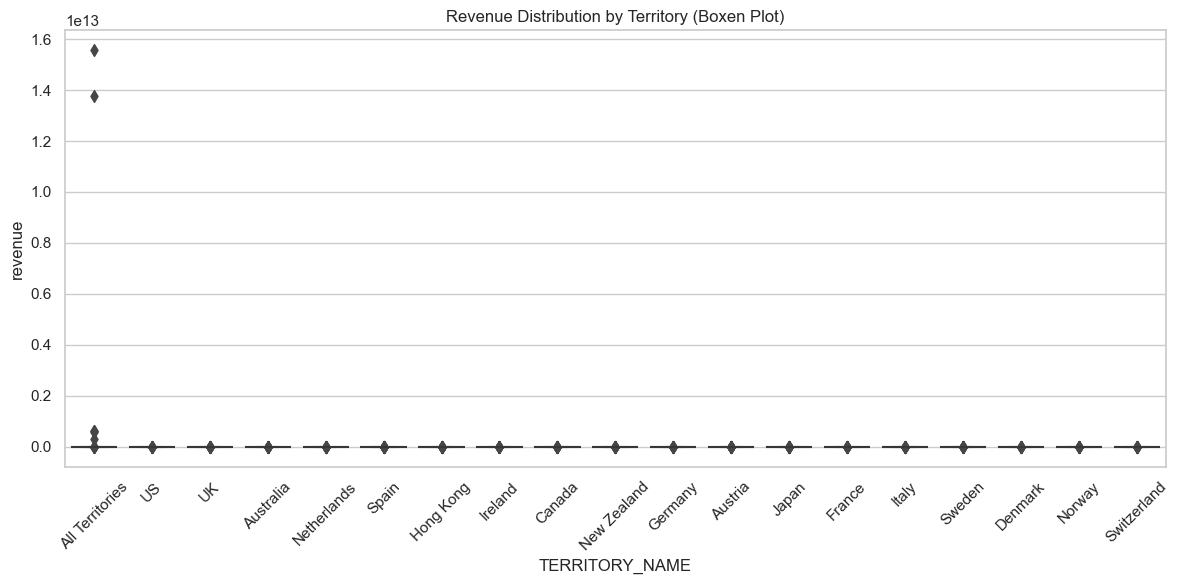

In [1211]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxenplot(x='TERRITORY_NAME', y='revenue', data=df)
plt.title('Revenue Distribution by Territory (Boxen Plot)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### ----- Same outlier in All Territories features generates outliers for Revenue

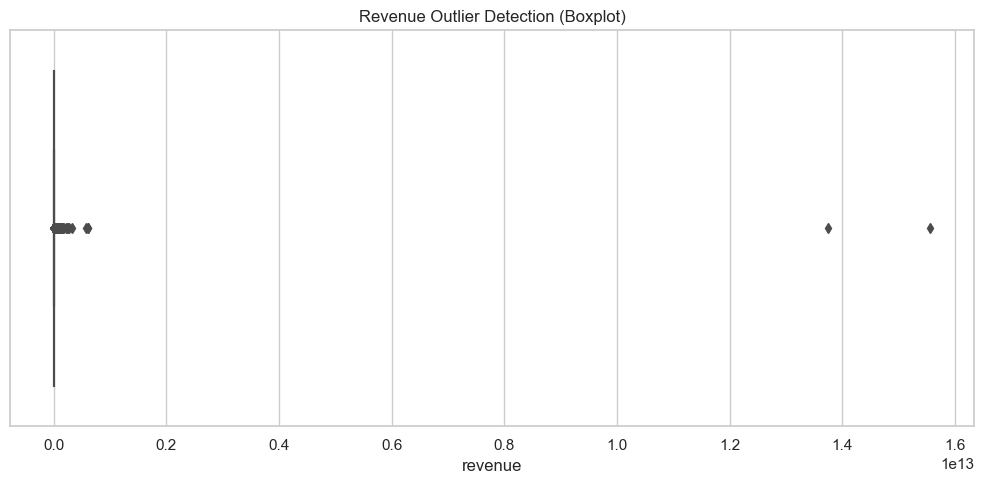

(21318, 132759, 16.06)

In [1213]:
# Plot revenue with outliers flagged
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['revenue'], showfliers=True)
plt.title('Revenue Outlier Detection (Boxplot)')
plt.tight_layout()
plt.show()

# Return outlier stats
outlier_count, total_count, round(outlier_count / total_count * 100, 2)

###  -----Apply log transformation

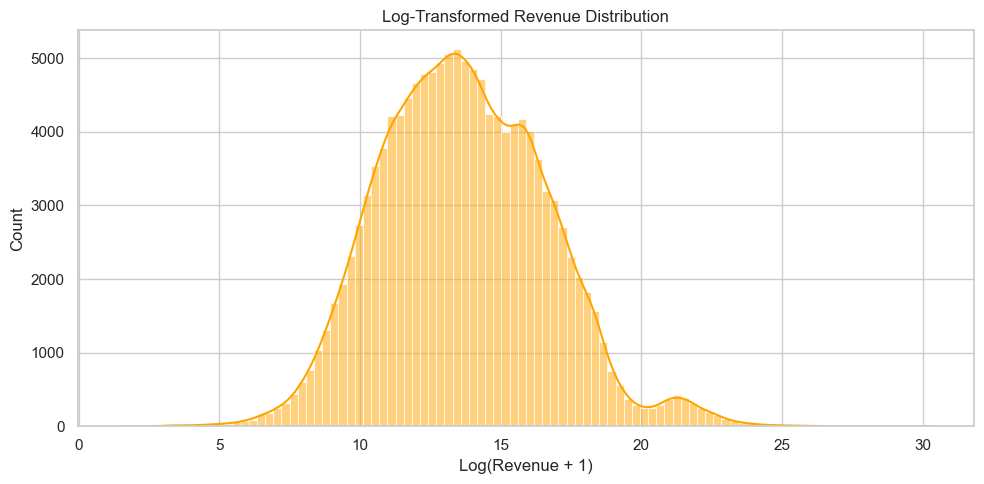

In [1215]:
# Apply log transformation
df['log_revenue'] = np.log1p(df['revenue'])

# Plot with yellow color
plt.figure(figsize=(10, 5))
sns.histplot(df['log_revenue'], kde=True, bins=100, color='orange')
plt.title('Log-Transformed Revenue Distribution')
plt.xlabel('Log(Revenue + 1)')
plt.tight_layout()
plt.show()


###  ----- Exclude 'All Territories' since it houses the outliers and it introduces redendancy to the dataset for ----------------modeling

In [1217]:
# Exclude 'All Territories'
df = df[df['TERRITORY_NAME'] != 'All Territories']

###  -------Copy and resample to weekly data

In [1219]:
# Copy and resample to weekly data
df_weekly = df.copy()
df_weekly.set_index('DATE_DAY', inplace=True)

###  ----  Aggregate by week and organisation, and Territory_Name

In [1221]:
# Aggregate by week and organisation
weekly_agg = df_weekly.groupby([pd.Grouper(freq='W'), 'ORGANISATION_ID', 'TERRITORY_NAME']).agg({
    'revenue': 'sum',
    'ALL_PURCHASES_UNITS': 'sum',
    'revenue_outlier': 'sum'
}).reset_index()

In [1222]:
# Add week number and year for exploration
weekly_agg['week'] = weekly_agg['DATE_DAY'].dt.isocalendar().week
weekly_agg['year'] = weekly_agg['DATE_DAY'].dt.year

weekly_agg.head()

DATE_DAY                   ORGANISATION_ID TERRITORY_NAME      revenue  \
0 2019-07-28  0d1fc3f1715b0c65776780e7ad8ac7df      Australia   1085348.25   
1 2019-08-04  0d1fc3f1715b0c65776780e7ad8ac7df      Australia   2108670.31   
2 2019-08-04  0d1fc3f1715b0c65776780e7ad8ac7df             UK  13036278.36   
3 2019-08-11  0d1fc3f1715b0c65776780e7ad8ac7df      Australia   2037757.70   
4 2019-08-11  0d1fc3f1715b0c65776780e7ad8ac7df             UK  32023135.52   

   ALL_PURCHASES_UNITS  revenue_outlier  week  year  
0                  134                0    30  2019  
1                  258                0    31  2019  
2                  746                0    31  2019  
3                  257                0    32  2019  
4                 1314                0    32  2019

In [1223]:
weekly_agg.shape

(7004, 8)

### --- Displaying Revenue contribution by Territory

In [1225]:
# Revenue by organisation
org_revenue = weekly_agg.groupby('TERRITORY_NAME',)['revenue'].sum().sort_values(ascending=False)
top_orgs = org_revenue.head(15)

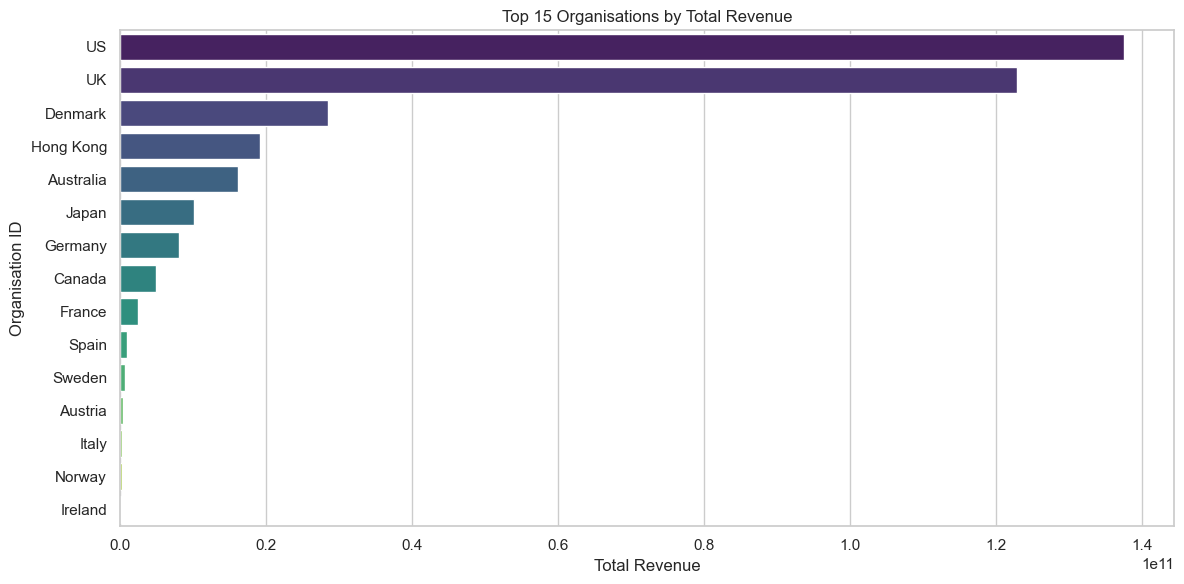

In [1226]:
# Plot top revenue contributors
plt.figure(figsize=(12, 6))
sns.barplot(x=top_orgs.values, y=top_orgs.index, palette='viridis')
plt.title('Top 15 Organisations by Total Revenue')
plt.xlabel('Total Revenue')
plt.ylabel('Organisation ID')
plt.tight_layout()
plt.show()

### --- Box plot showing no outlier on all Territory, haven removed All Territory feature

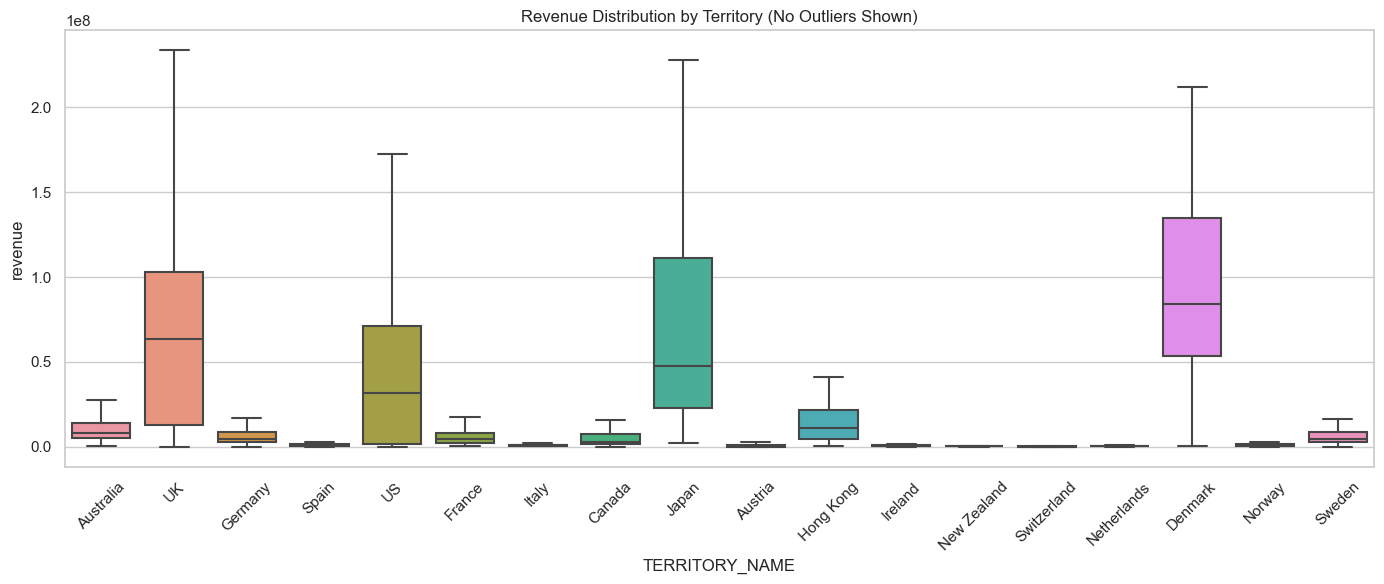

In [1228]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot revenue distribution boxplot for all territories
plt.figure(figsize=(14, 6))
sns.boxplot(data=weekly_agg, x='TERRITORY_NAME', y='revenue', showfliers=False)
plt.xticks(rotation=45)
plt.title('Revenue Distribution by Territory (No Outliers Shown)')
plt.tight_layout()
plt.show()


### --- Filter weekly_agg by top 10 territories/organisations

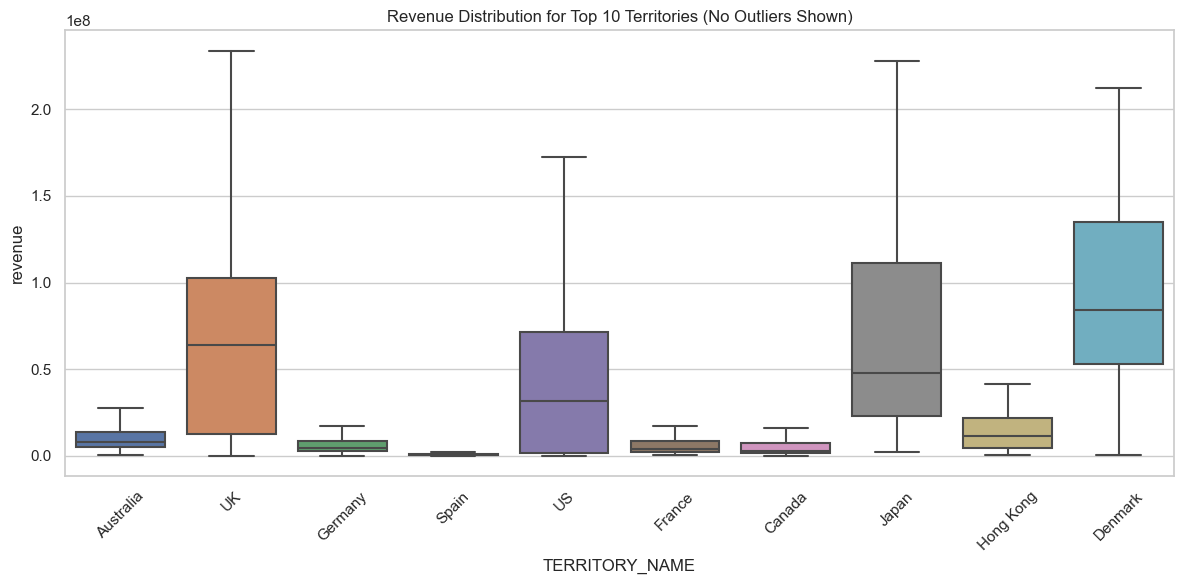

In [1230]:
# Filter weekly_agg by top 10 territories/organisations
top_10_territories = org_revenue.head(10).index.tolist()
filtered_weekly_agg = weekly_agg[weekly_agg['TERRITORY_NAME'].isin(top_10_territories)]

# Plot revenue distribution boxplot for top 9 territories
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_weekly_agg, x='TERRITORY_NAME', y='revenue', showfliers=False)
plt.xticks(rotation=45)
plt.title('Revenue Distribution for Top 10 Territories (No Outliers Shown)')
plt.tight_layout()
plt.show()

###  -------  Find outliers manually per territory using IQR

In [1232]:
# Find outliers per territory using IQR
def detect_outliers(group):
    q1 = group['revenue'].quantile(0.25)
    q3 = group['revenue'].quantile(0.75)
    iqr = q3 - q1
    upper_bound = q3 + 1.5 * iqr
    return group[group['revenue'] > upper_bound]

outliers = weekly_agg.groupby('TERRITORY_NAME').apply(detect_outliers)
outliers.head()

DATE_DAY                   ORGANISATION_ID  \
TERRITORY_NAME                                                    
Australia      51  2019-11-17  0d1fc3f1715b0c65776780e7ad8ac7df   
               61  2019-12-01  0d1fc3f1715b0c65776780e7ad8ac7df   
               418 2020-07-19  0d1fc3f1715b0c65776780e7ad8ac7df   
               423 2020-07-19  882ce7e286d66facc66518783e2192c7   
               706 2020-11-15  0d1fc3f1715b0c65776780e7ad8ac7df   

                   TERRITORY_NAME       revenue  ALL_PURCHASES_UNITS  \
TERRITORY_NAME                                                         
Australia      51       Australia  1.224827e+08                 1462   
               61       Australia  6.496641e+07                 1241   
               418      Australia  3.482897e+07                 1151   
               423      Australia  3.482886e+07                 1151   
               706      Australia  2.852250e+07                  911   

                    revenue_outlier  week  year  
TERRITORY_NAME                                   
Australia      51                 2    46  2019  
               61                 1    48  2019  
               418                0    29  2020  
               423                0    29  2020  
               706                0    46  2020

### --- Revenue trend line plot for top 10 territories

In [1234]:
# Step: Top 10 Territories by Total Revenue

# Total revenue by territory
territory_revenue = weekly_agg.groupby('TERRITORY_NAME')['revenue'].sum().sort_values(ascending=False)
top_10_territories = territory_revenue.head(10).index.tolist()
filtered_weekly_territory = weekly_agg[weekly_agg['TERRITORY_NAME'].isin(top_10_territories)]

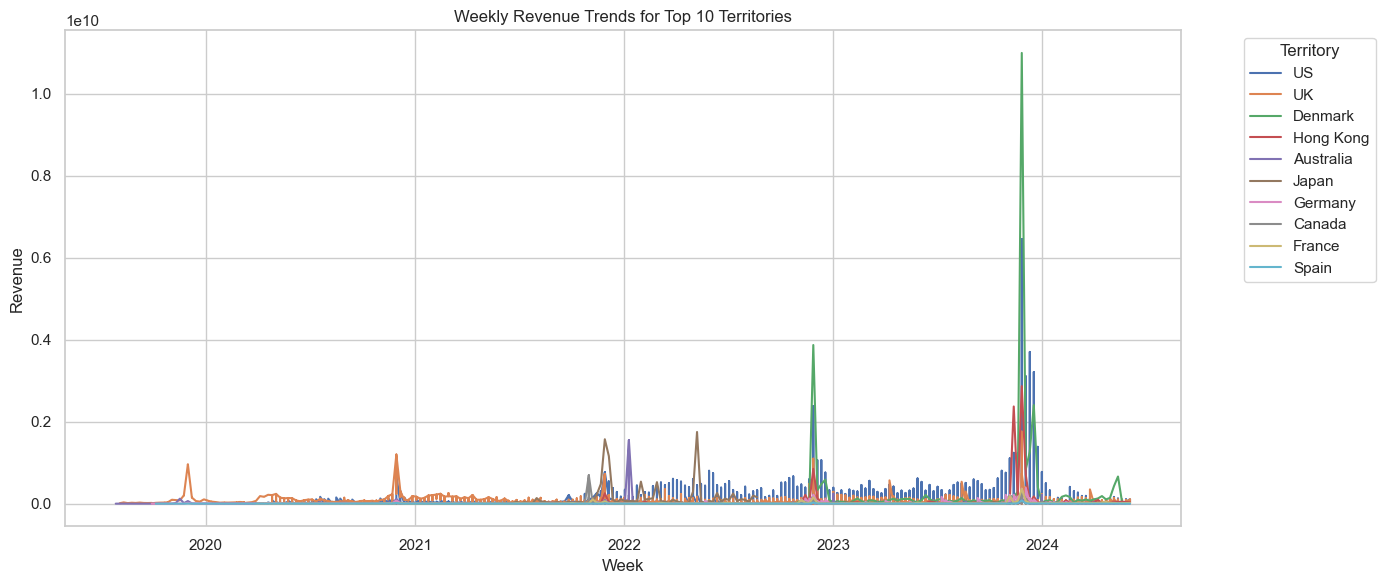

In [1235]:
# Revenue trend line plot for top 10 territories
plt.figure(figsize=(14, 6))
for territory in top_10_territories:
    territory_data = filtered_weekly_territory[filtered_weekly_territory['TERRITORY_NAME'] == territory]
    plt.plot(territory_data['DATE_DAY'], territory_data['revenue'], label=territory)

plt.title('Weekly Revenue Trends for Top 10 Territories')
plt.xlabel('Week')
plt.ylabel('Revenue')
plt.legend(title='Territory', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

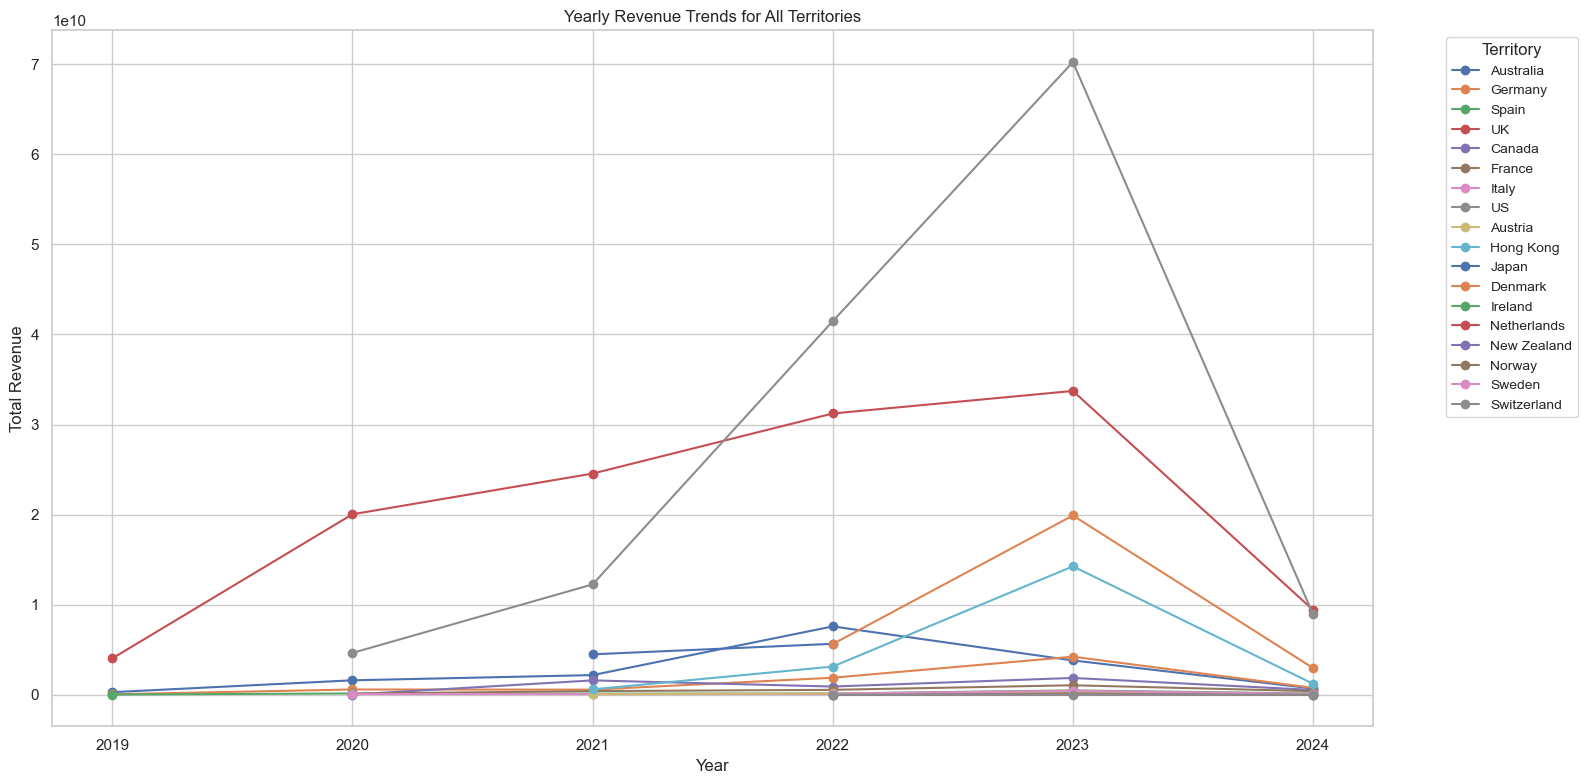

In [1236]:
# Aggregate revenue by year and territory
yearly_agg = weekly_agg.groupby(['year', 'TERRITORY_NAME'])['revenue'].sum().reset_index()

# Get all territory names
all_territories = yearly_agg['TERRITORY_NAME'].unique().tolist()

# Optional: remove "All Territories" if needed
# all_territories = [t for t in all_territories if t != "All Territories"]

# Plot revenue trends
plt.figure(figsize=(16, 8))
for territory in all_territories:
    territory_data = yearly_agg[yearly_agg['TERRITORY_NAME'] == territory]
    plt.plot(territory_data['year'], territory_data['revenue'], marker='o', label=territory)

plt.title('Yearly Revenue Trends for All Territories')
plt.xlabel('Year')
plt.ylabel('Total Revenue')
plt.legend(title='Territory', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

###  -----Pie chart of total revenue share

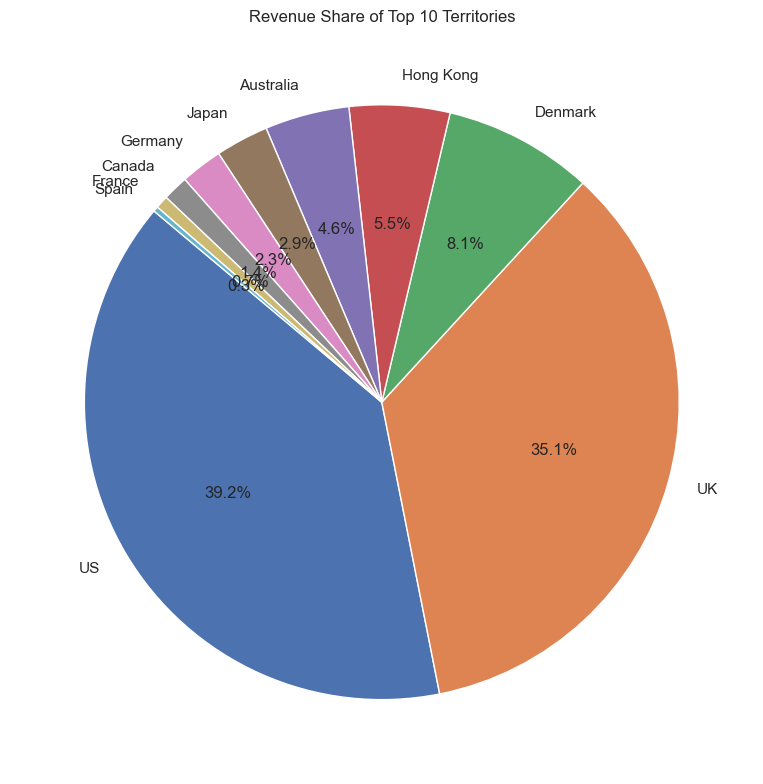

In [1238]:
# Pie chart of total revenue share
top_10_revenue_share = territory_revenue[top_10_territories]
plt.figure(figsize=(8, 8))
plt.pie(top_10_revenue_share, labels=top_10_territories, autopct='%1.1f%%', startangle=140)
plt.title('Revenue Share of Top 10 Territories')
plt.tight_layout()
plt.show()

###   ----- Total Spend by Channel Across Top 10 Territories

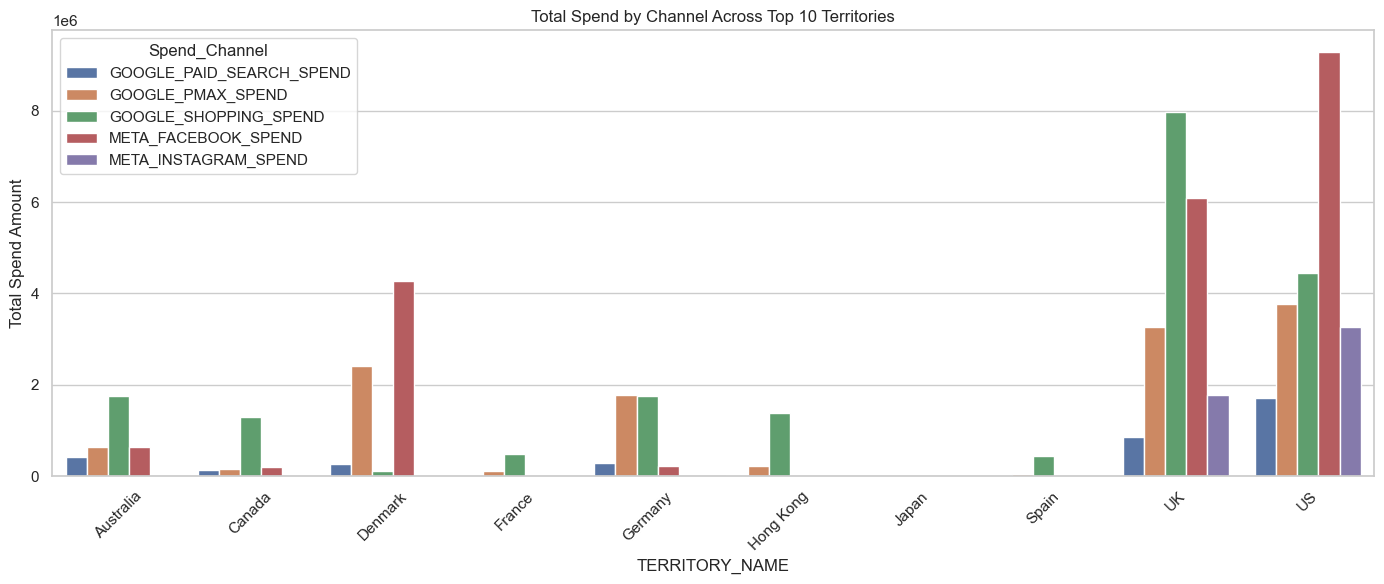

In [1240]:
# Step 1: Define spend columns (from df or weekly_features)
spend_vars = [col for col in df.columns if col.endswith('_SPEND')]

# Step 2: Create working copy of weekly_features
spend_rev = df.copy()

# Step 3: Focus on top 10 territories only
spend_rev = spend_rev[spend_rev['TERRITORY_NAME'].isin(top_10_territories)]

# Step 4: Melt the dataset for plotting
melted = spend_rev.melt(
    id_vars=['DATE_DAY', 'TERRITORY_NAME', 'revenue'],
    value_vars=spend_vars,
    var_name='Spend_Channel',
    value_name='Spend_Amount'
)

# Step 5: Aggregate total spend per country per channel
spend_summary = melted.groupby(['TERRITORY_NAME', 'Spend_Channel'])['Spend_Amount'].sum().reset_index()

# Step 6: Plot
plt.figure(figsize=(14, 6))
sns.barplot(data=spend_summary, x='TERRITORY_NAME', y='Spend_Amount', hue='Spend_Channel')
plt.title('Total Spend by Channel Across Top 10 Territories')
plt.ylabel('Total Spend Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


###  ------ Removing outliers identified by revenue  on the entire dataset for cleaner data

In [1469]:
# Remove outliers
Q1 = df['revenue'].quantile(0.25)
Q3 = df['revenue'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
df = df[df['revenue'] < upper_bound]

In [1471]:
# Re-run feature engineering
from sklearn.preprocessing import LabelEncoder

# Identify feature groups
spend_cols = [col for col in df.columns if '_SPEND' in col]
click_cols = [col for col in df.columns if '_CLICKS' in col]
impression_cols = [col for col in df.columns if '_IMPRESSIONS' in col]
purchase_cols = [
    'FIRST_PURCHASES_UNITS', 'FIRST_PURCHASES_ORIGINAL_PRICE', 'FIRST_PURCHASES_GROSS_DISCOUNT',
    'ALL_PURCHASES_UNITS', 'ALL_PURCHASES_ORIGINAL_PRICE', 'ALL_PURCHASES_GROSS_DISCOUNT'
]

###   --------weekly aggregation dictionary of data by date

In [1524]:
if 'DATE_DAY' in df.columns:
    df.set_index('DATE_DAY', inplace=True)
# Build aggregation dictionary
agg_dict = {col: 'sum' for col in spend_cols + click_cols + impression_cols + purchase_cols}
agg_dict.update({'revenue': 'sum'})

In [1525]:
# Aggregate
weekly_features = df.groupby([pd.Grouper(freq='W'), 'TERRITORY_NAME']).agg(agg_dict).reset_index()

In [1526]:
weekly_features.head()

DATE_DAY TERRITORY_NAME  GOOGLE_PAID_SEARCH_SPEND  GOOGLE_SHOPPING_SPEND  \
0 2019-07-28      Australia                       0.0                 555.70   
1 2019-08-04      Australia                       0.0                1031.96   
2 2019-08-04             UK                       0.0                1635.34   
3 2019-08-11      Australia                       0.0                 954.91   
4 2019-08-11             UK                       0.0                1569.34   

   GOOGLE_PMAX_SPEND  META_FACEBOOK_SPEND  META_INSTAGRAM_SPEND  \
0                0.0                  0.0                   0.0   
1                0.0                  0.0                   0.0   
2                0.0                  0.0                   0.0   
3                0.0                  0.0                   0.0   
4                0.0                  0.0                   0.0   

   GOOGLE_PAID_SEARCH_CLICKS  GOOGLE_SHOPPING_CLICKS  GOOGLE_PMAX_CLICKS  ...  \
0                        0.0                   741.0                 0.0  ...   
1                        0.0                  1383.0                 0.0  ...   
2                        0.0                  2623.0                 0.0  ...   
3                        0.0                  1192.0                 0.0  ...   
4                        0.0                  3344.0                 0.0  ...   

   GOOGLE_PMAX_IMPRESSIONS  META_FACEBOOK_IMPRESSIONS  \
0                      0.0                        0.0   
1                      0.0                        0.0   
2                      0.0                        0.0   
3                      0.0                        0.0   
4                      0.0                        0.0   

   META_INSTAGRAM_IMPRESSIONS  FIRST_PURCHASES_UNITS  \
0                         0.0                    124   
1                         0.0                    241   
2                         0.0                    726   
3                         0.0                    252   
4                         0.0                    972   

   FIRST_PURCHASES_ORIGINAL_PRICE  FIRST_PURCHASES_GROSS_DISCOUNT  \
0                        26326.99                         1433.35   
1                        51807.39                         7882.60   
2                        81439.02                         5790.24   
3                        50541.99                         5910.22   
4                       114768.63                        14211.20   

   ALL_PURCHASES_UNITS  ALL_PURCHASES_ORIGINAL_PRICE  \
0                  134                      28846.87   
1                  258                      53724.30   
2                  746                      83642.92   
3                  257                      51585.99   
4                 1024                     123010.33   

   ALL_PURCHASES_GROSS_DISCOUNT      revenue  
0                       1653.35   1085348.25  
1                       8212.13   2108670.31  
2                       5965.21  13036278.36  
3                       6199.14   2037757.70  
4                      15759.61  21384624.92  

[5 rows x 30 columns]

In [1527]:
weekly_features.shape

(2764, 30)

### --- CTR features

In [1529]:
# CTR features
for click, imp in zip(click_cols, impression_cols):
    ctr_col = click.replace('_CLICKS', '_CTR')
    weekly_features[ctr_col] = weekly_features[click] / (weekly_features[imp] + 1e-6)

### ---Efficiency features

In [1531]:
# Efficiency features
for col in spend_cols + click_cols:
    eff_col = f'{col}_EFFICIENCY'
    weekly_features[eff_col] = weekly_features['revenue'] / (weekly_features[col] + 1e-6)

### ---Time-based features

In [1533]:
# Time-based features
weekly_features['year'] = weekly_features['DATE_DAY'].dt.year
weekly_features['month'] = weekly_features['DATE_DAY'].dt.month
weekly_features['week'] = weekly_features['DATE_DAY'].dt.isocalendar().week

In [1534]:
# Encode TERRITORY_NAME
le = LabelEncoder()
weekly_features['TERRITORY_CODE'] = le.fit_transform(weekly_features['TERRITORY_NAME'])

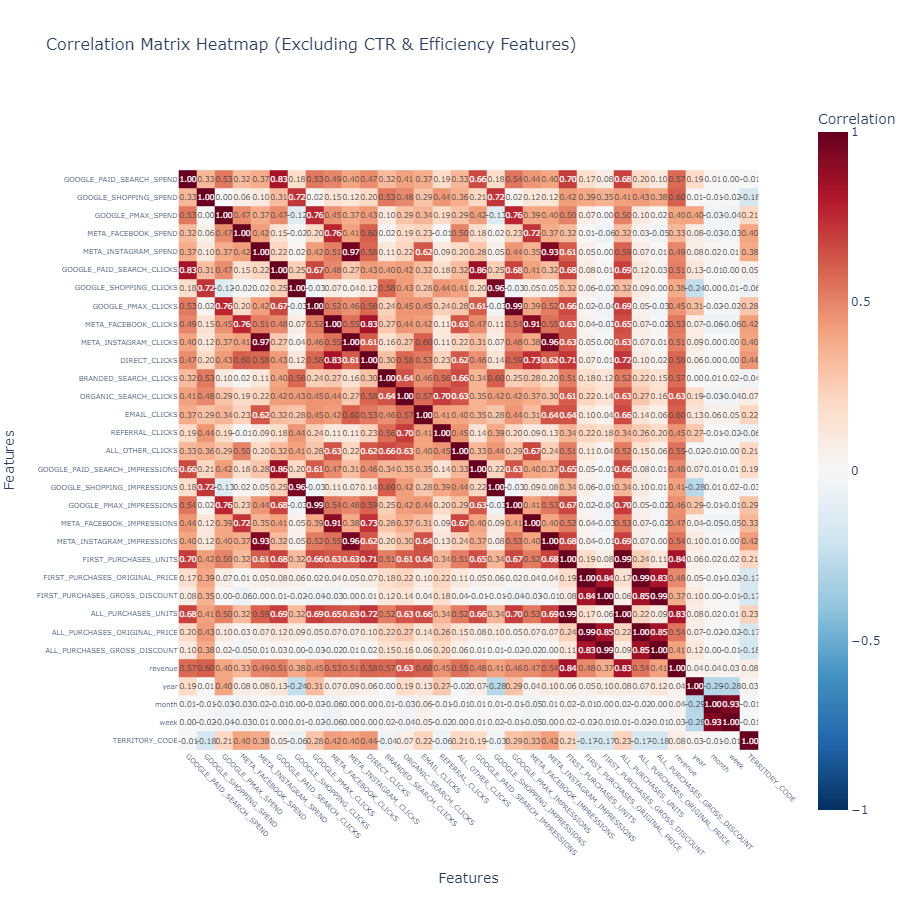

In [1535]:
# Filter out CTR and Efficiency columns
exclude_keywords = ['_CTR', '_EFFICIENCY']
selected_cols = [col for col in weekly_features.columns if all(kw not in col for kw in exclude_keywords)]

# Compute correlation matrix for selected numeric columns
correlation_matrix = weekly_features[selected_cols].corr(numeric_only=True).round(2)

# Create the interactive heatmap
fig = px.imshow(
    correlation_matrix,
    text_auto='.2f',
    color_continuous_scale='RdBu_r',
    title="Correlation Matrix Heatmap (Excluding CTR & Efficiency Features)",
    labels=dict(color="Correlation"),
    zmin=-1,
    zmax=1
)
# Increase the text size of the correlation numbers
fig.update_traces(textfont_size=7.5)  # Try 10–14 for readability

# Customize layout
fig.update_layout(
    title_font_size=16,
    xaxis=dict(
        tickangle=45,
        title="Features",
        tickfont=dict(size=7)
    ),
    yaxis=dict(
        title="Features",
        tickfont=dict(size=7)
    ),
    width=1000,
    height=900
)

# Show plot
fig.show()

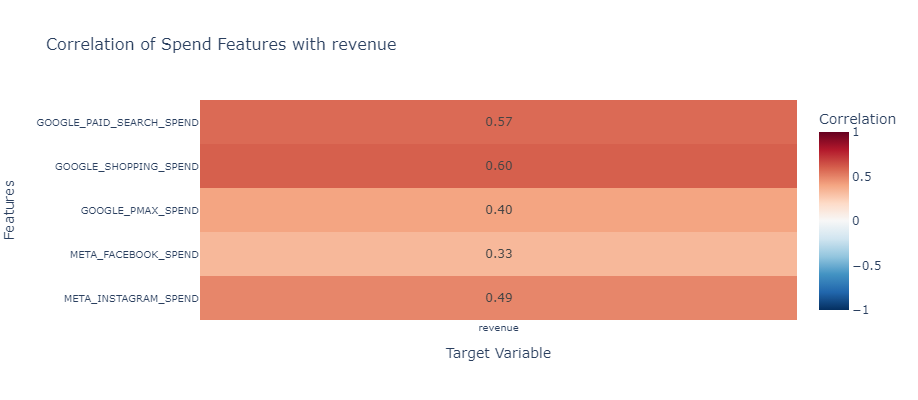

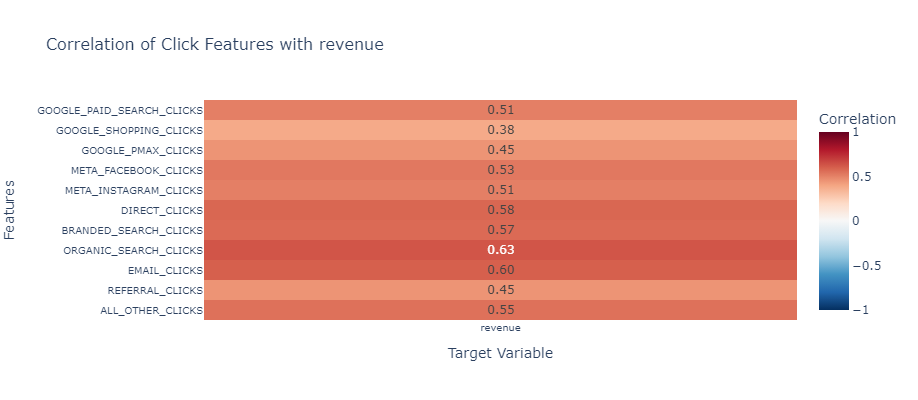

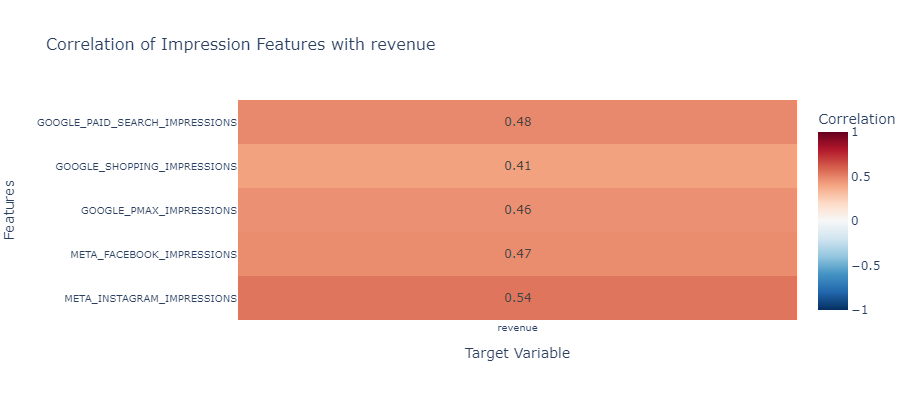

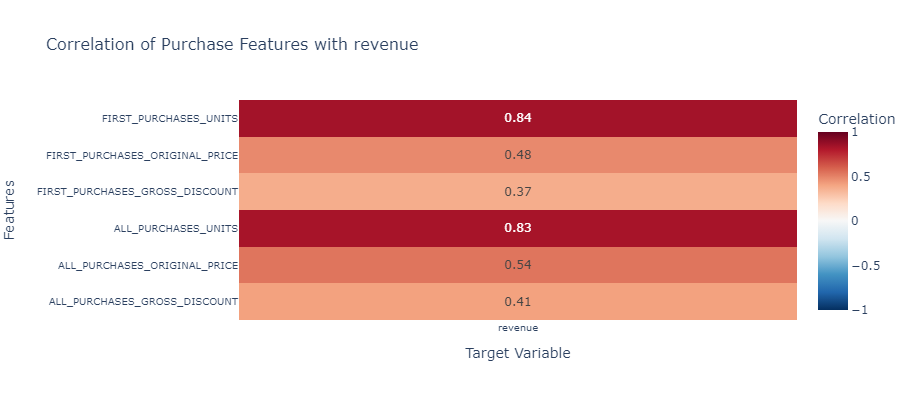

In [1536]:
# Define the target variable
target_var = 'revenue'

# Calculate correlation matrix
correlation_matrix = weekly_features.corr(numeric_only=True).round(2)

# Function to plot a single heatmap for a group
def plot_single_heatmap(group_cols, group_title):
    subset_corr = correlation_matrix.loc[[target_var], group_cols].T
    fig = px.imshow(
        subset_corr,
        text_auto='.2f',
        color_continuous_scale='RdBu_r',
        title=f"Correlation of {group_title} with {target_var}",
        labels=dict(color="Correlation"),
        zmin=-1,
        zmax=1,
        aspect="auto"
    )
    fig.update_layout(
        title_font_size=16,
        xaxis=dict(title="Target Variable", tickfont=dict(size=10)),
        yaxis=dict(title="Features", tickfont=dict(size=10)),
        width=500,
        height=400
    )
    fig.show()

# Create individual heatmaps
plot_single_heatmap(spend_cols, "Spend Features")
plot_single_heatmap(click_cols, "Click Features")
plot_single_heatmap(impression_cols, "Impression Features")
plot_single_heatmap(purchase_cols, "Purchase Features")


# ------------- Model Evaluation with Multicollinearity-Filtered Features

In [1538]:
import numpy as np
import pandas as pd

# Define correlation-based feature dropper
def get_correlated_features_to_drop_v1(df, threshold=0.85):
    corr_matrix_v1 = df.corr().abs()
    upper_tri_v1 = corr_matrix_v1.where(np.triu(np.ones(corr_matrix_v1.shape), k=1).astype(bool))
    to_drop_v1 = [col for col in upper_tri_v1.columns if any(upper_tri_v1[col] > threshold)]
    return to_drop_v1

# Exclude CTR, efficiency, and metadata
exclude_keywords_v1 = ['_CTR', '_EFFICIENCY']
exclude_cols_v1 = ['revenue', 'DATE_DAY', 'TERRITORY_NAME']

selected_cols_v1 = [
    col for col in weekly_features.columns
    if col not in exclude_cols_v1 and all(kw not in col for kw in exclude_keywords_v1)
]

# Numeric subset for correlation
numeric_df_v1 = weekly_features[selected_cols_v1].select_dtypes(include=['number'])

# Get correlated features to drop
redundant_features_v1 = get_correlated_features_to_drop_v1(numeric_df_v1, threshold=0.85)

In [1539]:
# Display as DataFrame
redundant_df_v1 = pd.DataFrame(redundant_features_v1, columns=["Redundant Feature"])
display(redundant_df_v1)

Redundant Feature
0           META_INSTAGRAM_CLICKS
1  GOOGLE_PAID_SEARCH_IMPRESSIONS
2     GOOGLE_SHOPPING_IMPRESSIONS
3         GOOGLE_PMAX_IMPRESSIONS
4       META_FACEBOOK_IMPRESSIONS
5      META_INSTAGRAM_IMPRESSIONS
6             ALL_PURCHASES_UNITS
7    ALL_PURCHASES_ORIGINAL_PRICE
8    ALL_PURCHASES_GROSS_DISCOUNT
9                            week

In [1540]:
# Get retained features
all_features_v1 = numeric_df_v1.columns.tolist()
retained_features_v1 = [col for col in all_features_v1 if col not in redundant_features_v1]

retained_df_v1 = pd.DataFrame(retained_features_v1, columns=["Retained Feature"])
display(retained_df_v1)

Retained Feature
0         GOOGLE_PAID_SEARCH_SPEND
1            GOOGLE_SHOPPING_SPEND
2                GOOGLE_PMAX_SPEND
3              META_FACEBOOK_SPEND
4             META_INSTAGRAM_SPEND
5        GOOGLE_PAID_SEARCH_CLICKS
6           GOOGLE_SHOPPING_CLICKS
7               GOOGLE_PMAX_CLICKS
8             META_FACEBOOK_CLICKS
9                    DIRECT_CLICKS
10           BRANDED_SEARCH_CLICKS
11           ORGANIC_SEARCH_CLICKS
12                    EMAIL_CLICKS
13                 REFERRAL_CLICKS
14                ALL_OTHER_CLICKS
15           FIRST_PURCHASES_UNITS
16  FIRST_PURCHASES_ORIGINAL_PRICE
17  FIRST_PURCHASES_GROSS_DISCOUNT
18                            year
19                           month
20                  TERRITORY_CODE

In [1541]:
# Your manually retained features + week (excluding month/year)
manual_retained_features_v1 = [
    "GOOGLE_PAID_SEARCH_SPEND",
    "GOOGLE_SHOPPING_SPEND",
    "GOOGLE_PMAX_SPEND",
    "META_FACEBOOK_SPEND",
    "META_INSTAGRAM_SPEND",
    "GOOGLE_PMAX_CLICKS",
    "META_FACEBOOK_CLICKS",
    "BRANDED_SEARCH_CLICKS",
    "ORGANIC_SEARCH_CLICKS",
    "EMAIL_CLICKS",
    "ALL_OTHER_CLICKS",
    "FIRST_PURCHASES_UNITS",
    "FIRST_PURCHASES_ORIGINAL_PRICE",
    "TERRITORY_CODE"
]

final_features_v1 = manual_retained_features_v1 + ["week"]

In [1542]:
#Prepare input matrix
X_v1 = weekly_features[final_features_v1]
y_v1 = weekly_features["revenue"]

In [1543]:
X_v1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2764 entries, 0 to 2763
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   GOOGLE_PAID_SEARCH_SPEND        2764 non-null   float64
 1   GOOGLE_SHOPPING_SPEND           2764 non-null   float64
 2   GOOGLE_PMAX_SPEND               2764 non-null   float64
 3   META_FACEBOOK_SPEND             2764 non-null   float64
 4   META_INSTAGRAM_SPEND            2764 non-null   float64
 5   GOOGLE_PMAX_CLICKS              2764 non-null   float64
 6   META_FACEBOOK_CLICKS            2764 non-null   float64
 7   BRANDED_SEARCH_CLICKS           2764 non-null   float64
 8   ORGANIC_SEARCH_CLICKS           2764 non-null   float64
 9   EMAIL_CLICKS                    2764 non-null   float64
 10  ALL_OTHER_CLICKS                2764 non-null   float64
 11  FIRST_PURCHASES_UNITS           2764 non-null   int64  
 12  FIRST_PURCHASES_ORIGINAL_PRICE  27

In [1544]:
X_v1.shape

(2764, 15)

In [1545]:
#Scale
scaler_v1 = StandardScaler()
X_scaled_v1 = scaler_v1.fit_transform(X_v1)

#Split
X_train_v1, X_test_v1, y_train_v1, y_test_v1 = train_test_split(X_scaled_v1, y_v1, test_size=0.2, shuffle=False)

In [1546]:
#Random Forest Tuning
rf_params_v1 = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_v1 = RandomForestRegressor(random_state=42)
rf_grid_v1 = GridSearchCV(rf_v1, rf_params_v1, cv=3, scoring='r2', n_jobs=-1)
rf_grid_v1.fit(X_train_v1, y_train_v1)
best_rf_v1 = rf_grid_v1.best_estimator_

In [1547]:
#XGBoost Tuning
xgb_params_v1 = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0]
}
xgb_model_v1 = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_grid_v1 = GridSearchCV(xgb_model_v1, xgb_params_v1, cv=3, scoring='r2', n_jobs=-1)
xgb_grid_v1.fit(X_train_v1, y_train_v1)
best_xgb_v1 = xgb_grid_v1.best_estimator_

In [1548]:
#Define models
models_v1 = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": best_rf_v1,
    "XGBoost": best_xgb_v1
}

In [1549]:
#Evaluate models
results_v1 = {}
for name, model in models_v1.items():
    model.fit(X_train_v1, y_train_v1)
    y_pred = model.predict(X_test_v1)
    results_v1[name] = {
        'R²': r2_score(y_test_v1, y_pred),
        'MAPE': mean_absolute_percentage_error(y_test_v1, y_pred),
        'MAE': mean_absolute_error(y_test_v1, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test_v1, y_pred))
    }
#View performance
pd.DataFrame(results_v1).T.sort_values(by='R²', ascending=False)

R²        MAPE           MAE          RMSE
XGBoost            0.918834    8.043128  2.732173e+06  4.026680e+06
Random Forest      0.898984    0.922504  2.923252e+06  4.492158e+06
Ridge Regression   0.802495  187.790944  4.237768e+06  6.281287e+06
Linear Regression  0.801833  188.035511  4.242446e+06  6.291810e+06

### --- Predicted vs Actual (Raw Setup)

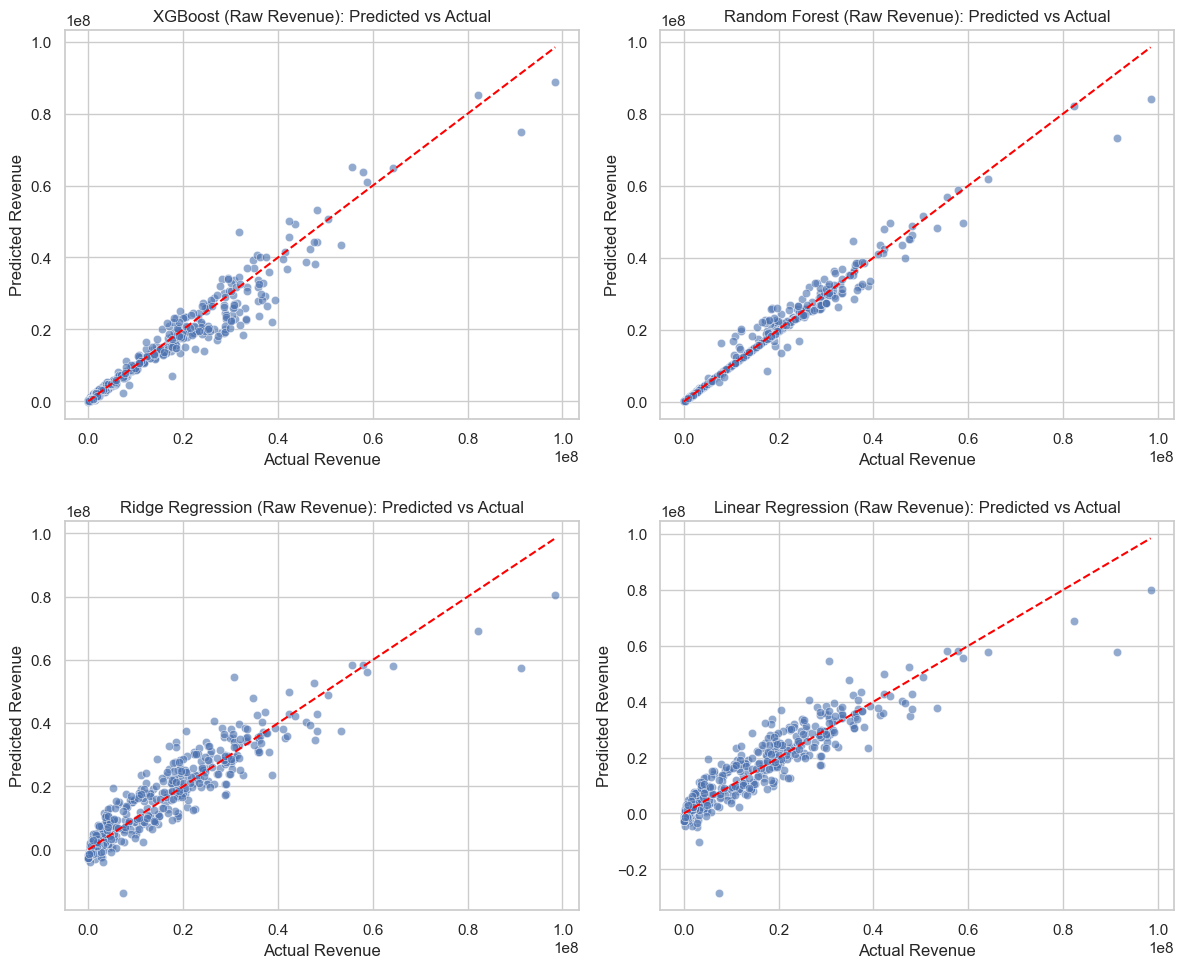

In [1550]:
#Predicted vs Actual (Raw Setup)
X_raw_v1 = weekly_features.drop(columns=['DATE_DAY', 'TERRITORY_NAME', 'revenue'])
y_raw_v1 = weekly_features['revenue']
X_scaled_raw_v1 = scaler_v1.fit_transform(X_raw_v1)
X_train_raw_v1, X_test_raw_v1, y_train_raw_v1, y_test_raw_v1 = train_test_split(X_scaled_raw_v1, y_raw_v1, test_size=0.2, shuffle=False)

models_raw_v1 = {
    "XGBoost": best_xgb_v1,
    "Random Forest": best_rf_v1,
    "Ridge Regression": Ridge(alpha=1.0),
    "Linear Regression": LinearRegression()
}

plt.figure(figsize=(12, 10))
for i, (name, model) in enumerate(models_raw_v1.items(), 1):
    model.fit(X_train_raw_v1, y_train_raw_v1)
    y_pred = model.predict(X_test_raw_v1)
    plt.subplot(2, 2, i)
    sns.scatterplot(x=y_test_raw_v1, y=y_pred, alpha=0.6)
    plt.plot([y_test_raw_v1.min(), y_test_raw_v1.max()], [y_test_raw_v1.min(), y_test_raw_v1.max()], color='red', linestyle='--')
    plt.title(f'{name} (Raw Revenue): Predicted vs Actual')
    plt.xlabel('Actual Revenue')
    plt.ylabel('Predicted Revenue')

plt.tight_layout()
plt.show()


# -----------Puting 4 MODELS to Comparism on All numerical variables

In [1552]:
# Drop all columns that contain '_CTR' along with DATE_DAY, TERRITORY_NAME, and revenue
X = weekly_features.drop(
    columns=[col for col in weekly_features.columns if 'CTR' in col or col in ['DATE_DAY', 'TERRITORY_NAME', 'revenue']]
)

# Define target
y = weekly_features['revenue']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Time-aware split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

In [1553]:
X.shape

(2764, 47)

In [1554]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2764 entries, 0 to 2763
Data columns (total 47 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   GOOGLE_PAID_SEARCH_SPEND              2764 non-null   float64
 1   GOOGLE_SHOPPING_SPEND                 2764 non-null   float64
 2   GOOGLE_PMAX_SPEND                     2764 non-null   float64
 3   META_FACEBOOK_SPEND                   2764 non-null   float64
 4   META_INSTAGRAM_SPEND                  2764 non-null   float64
 5   GOOGLE_PAID_SEARCH_CLICKS             2764 non-null   float64
 6   GOOGLE_SHOPPING_CLICKS                2764 non-null   float64
 7   GOOGLE_PMAX_CLICKS                    2764 non-null   float64
 8   META_FACEBOOK_CLICKS                  2764 non-null   float64
 9   META_INSTAGRAM_CLICKS                 2764 non-null   float64
 10  DIRECT_CLICKS                         2764 non-null   float64
 11  BRANDED_SEARCH_CL

## ----------------------Hyperparameter Tuning for ML models

In [1556]:
# Step 2: Optional - Tune Random Forest
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestRegressor(random_state=42)
rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring='r2', n_jobs=-1)
rf_grid.fit(X_train, y_train)

# Replace the default RF model with the best one
best_rf = rf_grid.best_estimator_

In [1557]:
# Step 3: Optional - Tune XGBoost
import xgboost as xgb

xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=3, scoring='r2', n_jobs=-1)
xgb_grid.fit(X_train, y_train)

# Replace the default XGBoost model with the best one
best_xgb = xgb_grid.best_estimator_

In [1558]:
from sklearn.linear_model import LinearRegression, Ridge

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": best_rf,         # use tuned model
    "XGBoost": best_xgb               # use tuned model
}

## ---------------------Raw Revenue

In [1560]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
import numpy as np

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        'R²': r2_score(y_test, y_pred),
        'MAPE': mean_absolute_percentage_error(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
    }

pd.DataFrame(results).T.sort_values(by='R²', ascending=False)

R²        MAPE           MAE          RMSE
Random Forest      0.977872    1.634465  8.450846e+05  2.102462e+06
XGBoost            0.967374    7.231887  1.464709e+06  2.552957e+06
Ridge Regression   0.879187  119.016101  3.411363e+06  4.912645e+06
Linear Regression  0.878676  118.721835  3.436643e+06  4.923042e+06

## ---------------------Log Revenue(no Inverse)

In [1562]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
import numpy as np

# Modeling setup with log-transformed revenue
X = weekly_features.drop(columns=['DATE_DAY', 'TERRITORY_NAME', 'revenue'])
y = np.log1p(weekly_features['revenue'])  # Use log1p directly
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Train and evaluate models directly on log scale
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)  # log-scale prediction
    results[name] = {
        'R²': r2_score(y_test, y_pred),
        'MAPE': mean_absolute_percentage_error(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
    }

# Display results
pd.DataFrame(results).T.sort_values(by='R²', ascending=False)

R²      MAPE       MAE      RMSE
XGBoost            0.968937  0.012769  0.159579  0.328931
Random Forest      0.961681  0.008927  0.099019  0.365335
Ridge Regression   0.558555  0.055576  0.797217  1.239996
Linear Regression  0.426148  0.057611  0.827693  1.413780

## ----------------------------Predicted vs Actual 

## Raw Revenue (XGBoost & Linear Regression)

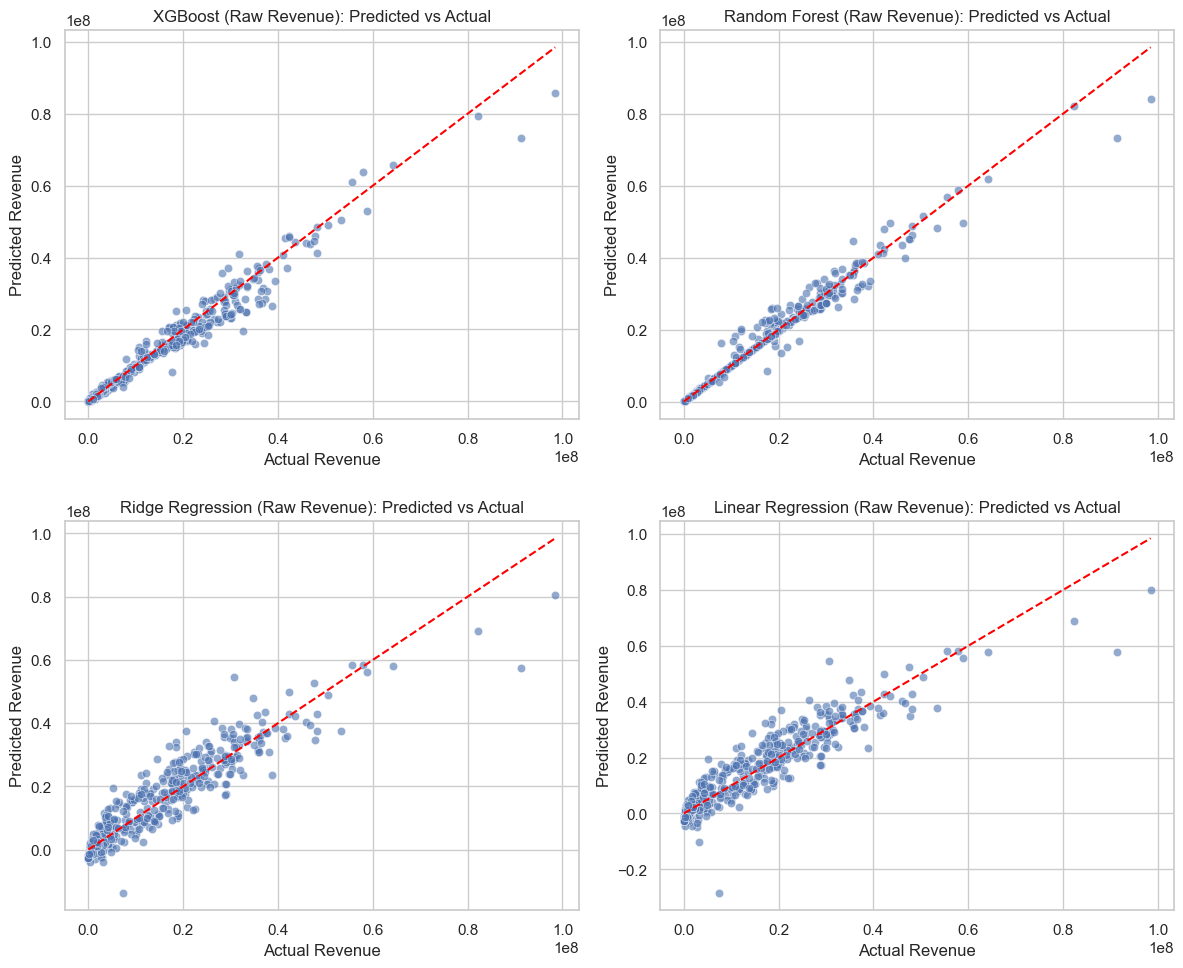

In [1565]:
# Setup 1: Raw revenue
X = weekly_features.drop(columns=['DATE_DAY', 'TERRITORY_NAME', 'revenue'])
y_raw = weekly_features['revenue']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_scaled, y_raw, test_size=0.2, shuffle=False)

# Use tuned models (assumes best_xgb and best_rf were obtained using GridSearchCV)
models_raw = {
    "XGBoost": best_xgb,
    "Random Forest": best_rf,
    "Ridge Regression": Ridge(alpha=1.0),
    "Linear Regression": LinearRegression()
}

# Plot predicted vs actual for all models
plt.figure(figsize=(12, 10))
for i, (name, model) in enumerate(models_raw.items(), 1):
    model.fit(X_train_raw, y_train_raw)
    y_pred = model.predict(X_test_raw)
    plt.subplot(2, 2, i)
    sns.scatterplot(x=y_test_raw, y=y_pred, alpha=0.6)
    plt.plot([y_test_raw.min(), y_test_raw.max()], [y_test_raw.min(), y_test_raw.max()], color='red', linestyle='--')
    plt.title(f'{name} (Raw Revenue): Predicted vs Actual')
    
    plt.xlabel('Actual Revenue')
    plt.ylabel('Predicted Revenue')

plt.tight_layout()
plt.show()

## Log-Transformed Revenue (No Inverse Transform)

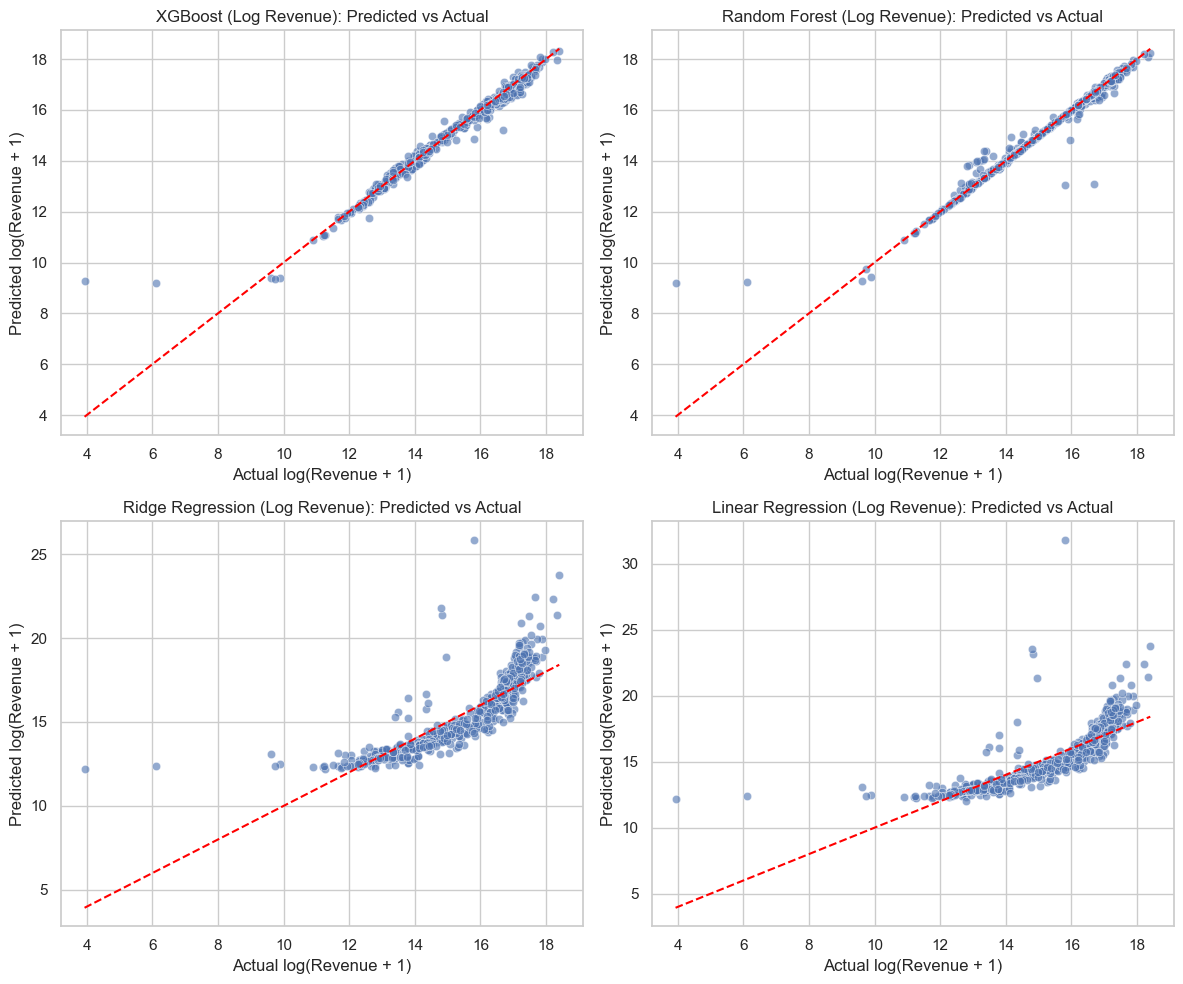

In [1567]:
# Setup 2: Log revenue (no inverse transform)
X = weekly_features.drop(columns=['DATE_DAY', 'TERRITORY_NAME', 'revenue'])
y_log = np.log1p(weekly_features['revenue'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_scaled, y_log, test_size=0.2, shuffle=False)

# Use tuned models for XGBoost and Random Forest
models_log = {
    "XGBoost": best_xgb,
    "Random Forest": best_rf,
    "Ridge Regression": Ridge(alpha=1.0),
    "Linear Regression": LinearRegression()
}

# Plot predicted vs actual in log scale
plt.figure(figsize=(12, 10))
for i, (name, model) in enumerate(models_log.items(), 1):
    model.fit(X_train_log, y_train_log)
    y_pred = model.predict(X_test_log)
    plt.subplot(2, 2, i)
    sns.scatterplot(x=y_test_log, y=y_pred, alpha=0.6)
    plt.plot([y_test_log.min(), y_test_log.max()], [y_test_log.min(), y_test_log.max()], color='red', linestyle='--')
    plt.title(f'{name} (Log Revenue): Predicted vs Actual')
    plt.xlabel('Actual log(Revenue + 1)')
    plt.ylabel('Predicted log(Revenue + 1)')

plt.tight_layout()
plt.show()

### ----------- Feature importance via XGBoost for Top 15 features on tunned features

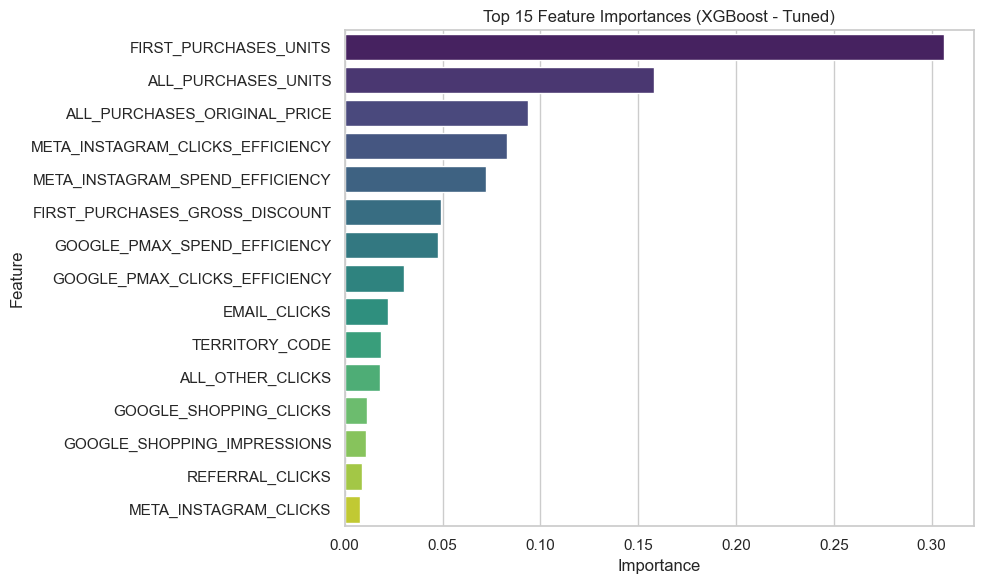

In [1569]:
# Feature importance via tuned XGBoost
X = weekly_features.drop(columns=['DATE_DAY', 'TERRITORY_NAME', 'revenue'])
y = weekly_features['revenue']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Use tuned model
xgb_model = best_xgb
xgb_model.fit(X_train, y_train)

importances = xgb_model.feature_importances_
feature_names = X.columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False).head(15)

# Plot top 15 features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
plt.title('Top 15 Feature Importances (XGBoost - Tuned)')
plt.tight_layout()
plt.show()

###  ---------Feature importance via XGBoost

In [1571]:
# Feature importance via XGBoost
X = weekly_features.drop(columns=['DATE_DAY', 'TERRITORY_NAME', 'revenue'])
y = weekly_features['revenue']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

In [1572]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_

### -----------    Top 15 features on non tunned features

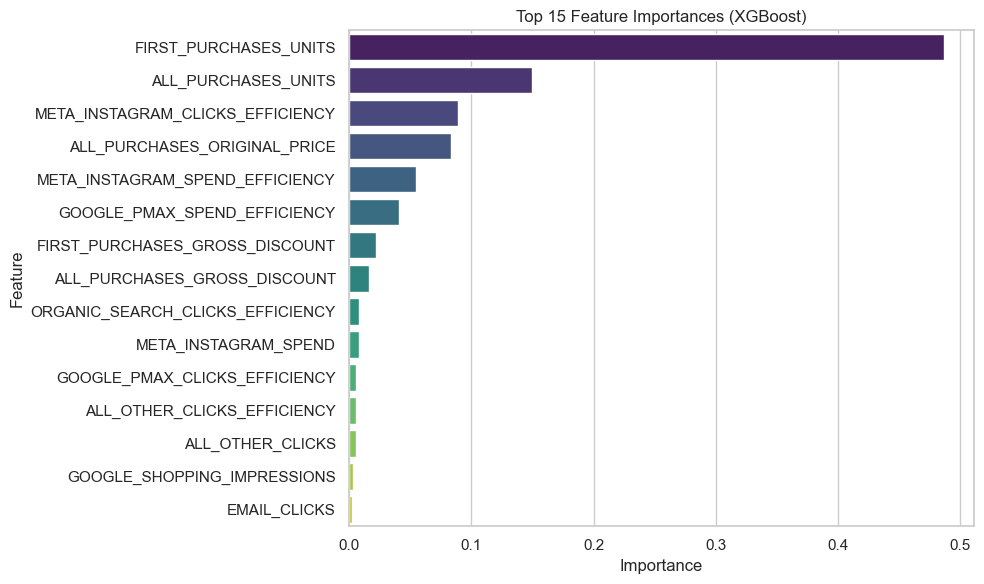

In [1574]:
# Plot top 15 features
feature_names = X.columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
plt.title('Top 15 Feature Importances (XGBoost)')
plt.tight_layout()
plt.show()

###   --------------Function to plot top N features per group

In [1576]:
# Train XGBoost model
xgb_model = best_xgb #XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Segment feature importances
feature_names = X.columns.tolist()
importances = xgb_model.feature_importances_
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Define category groups by name pattern
spend_feats = [f for f in feature_names if '_SPEND' in f]
click_feats = [f for f in feature_names if '_CLICKS' in f]
impression_feats = [f for f in feature_names if '_IMPRESSIONS' in f]
purchase_feats = [f for f in feature_names if 'PURCHASES' in f and f not in click_feats + impression_feats + spend_feats]

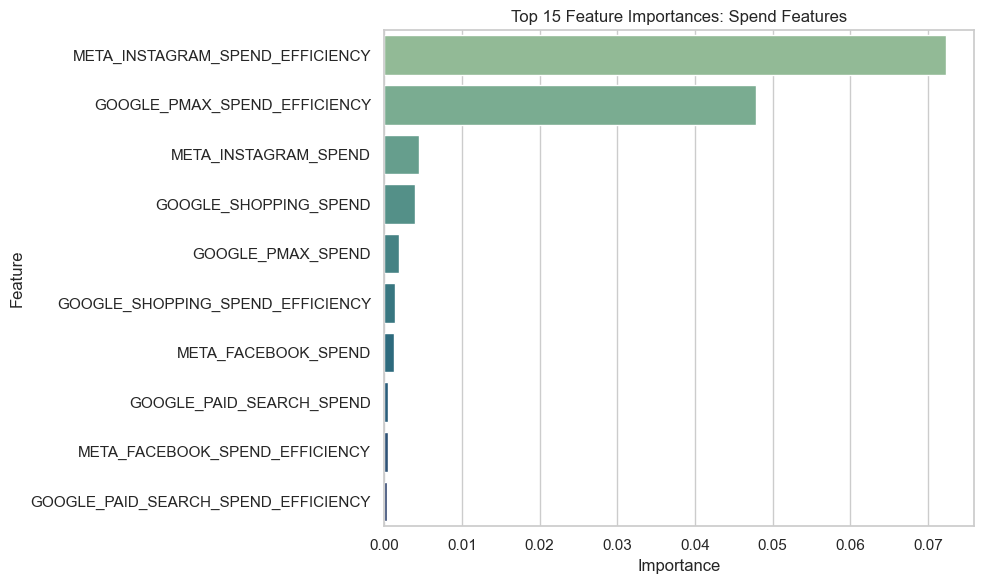

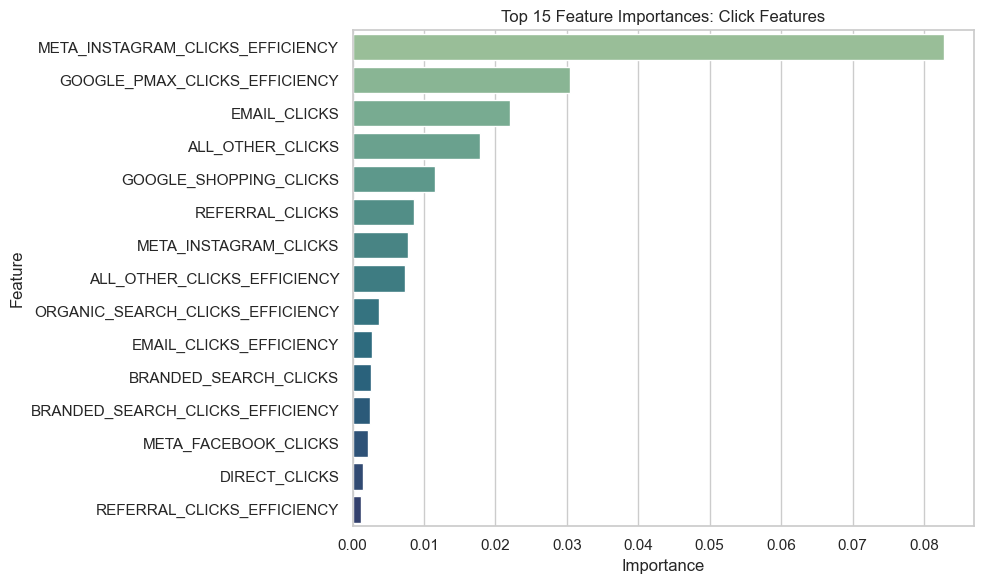

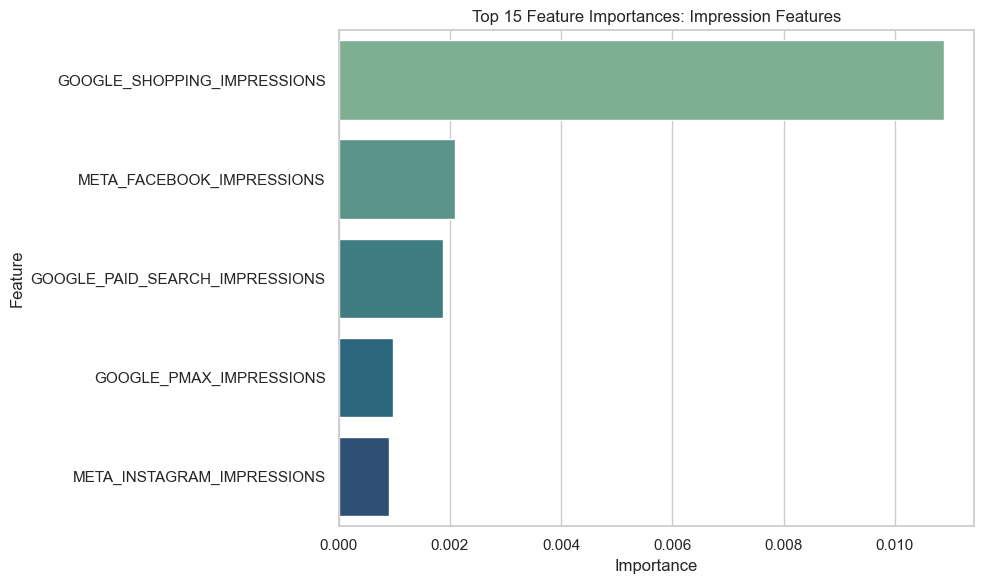

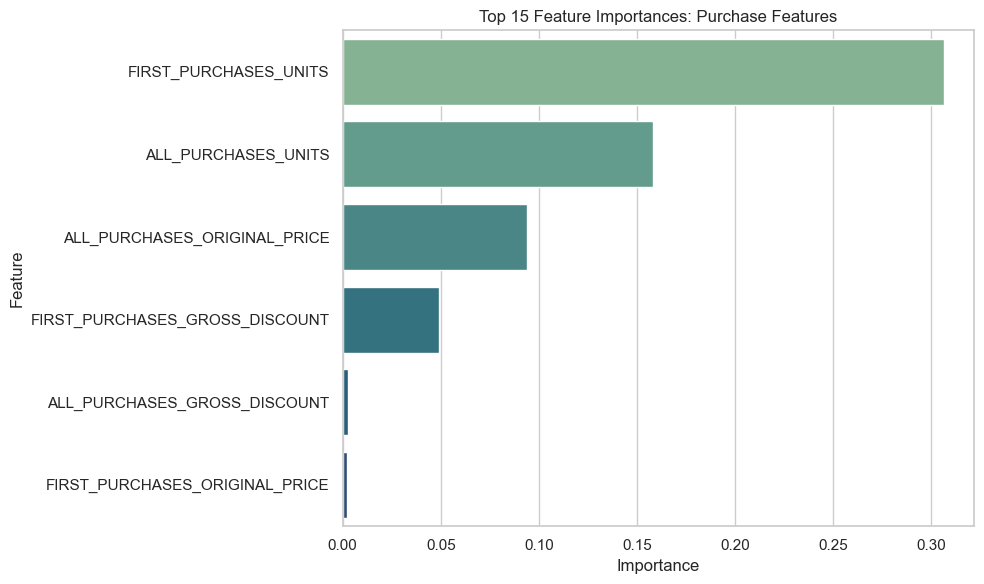

In [1577]:
# Function to plot top N features per group
def top_features_by_group(group_list, label, top_n=15):
    group_df = importance_df[importance_df['Feature'].isin(group_list)].sort_values(by='Importance', ascending=False).head(top_n)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=group_df, palette='crest')
    plt.title(f'Top {top_n} Feature Importances: {label}')
    plt.tight_layout()
    plt.show()

# Generate plots for each group
top_features_by_group(spend_feats, "Spend Features")
top_features_by_group(click_feats, "Click Features")
top_features_by_group(impression_feats, "Impression Features")
top_features_by_group(purchase_feats, "Purchase Features")


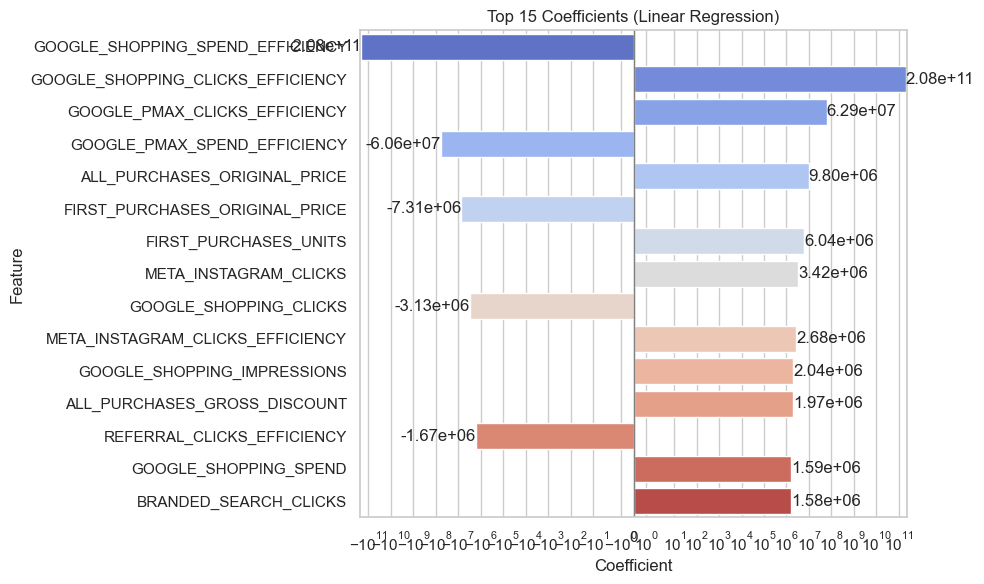

In [1578]:
# Assuming you already have X_train and y_train
# And X has column names

# Fit linear regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Create coef_df with features and coefficients
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lin_reg.coef_
})

# Sort by absolute value of coefficients
coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index).head(15)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='coolwarm')
plt.axvline(0, color='grey', linewidth=1)
plt.xscale('symlog')  # Symmetric log scale helps visualize wide range
plt.title('Top 15 Coefficients (Linear Regression)')

# Add coefficient values as text labels
for i, val in enumerate(coef_df['Coefficient']):
    plt.text(val, i, f"{val:.2e}", va='center', ha='left' if val > 0 else 'right')

plt.tight_layout()
plt.show()


###  ----- Local Explanation of Prediction Using SHAP Force Plot

###  ---- Based Interpretation per Feature Group and Global Summary

In [1581]:
shap.initjs()

def analyze_group_with_shap(df, target_col, feature_group, group_name="Feature Group", use_tuned_model=False):
    """
    Train XGBoost on a feature group, compute SHAP values, and show summary plot.
    """

    # Check feature group validity
    missing = [f for f in feature_group if f not in df.columns]
    if missing:
        raise ValueError(f"Missing features in DataFrame: {missing}")

    X = df[feature_group]
    y = df[target_col]

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

    # Model
    model = best_xgb
    model.fit(X_train, y_train)

    # SHAP explanation
    explainer = shap.Explainer(model, X_train, feature_names=feature_group)
    shap_values = explainer(X_test)

    # Optional metrics
    y_pred = model.predict(X_test)
    print(f"🔍 SHAP Feature Importance for {group_name}")
    print(f"R² = {r2_score(y_test, y_pred):.4f} | MAPE = {mean_absolute_percentage_error(y_test, y_pred) * 100:.2f}%")

    # SHAP summary plot
    shap.summary_plot(shap_values, X_test, feature_names=feature_group, max_display=15)


###  ---- global feature ranking using SHAP also overall explainability and top driver insights

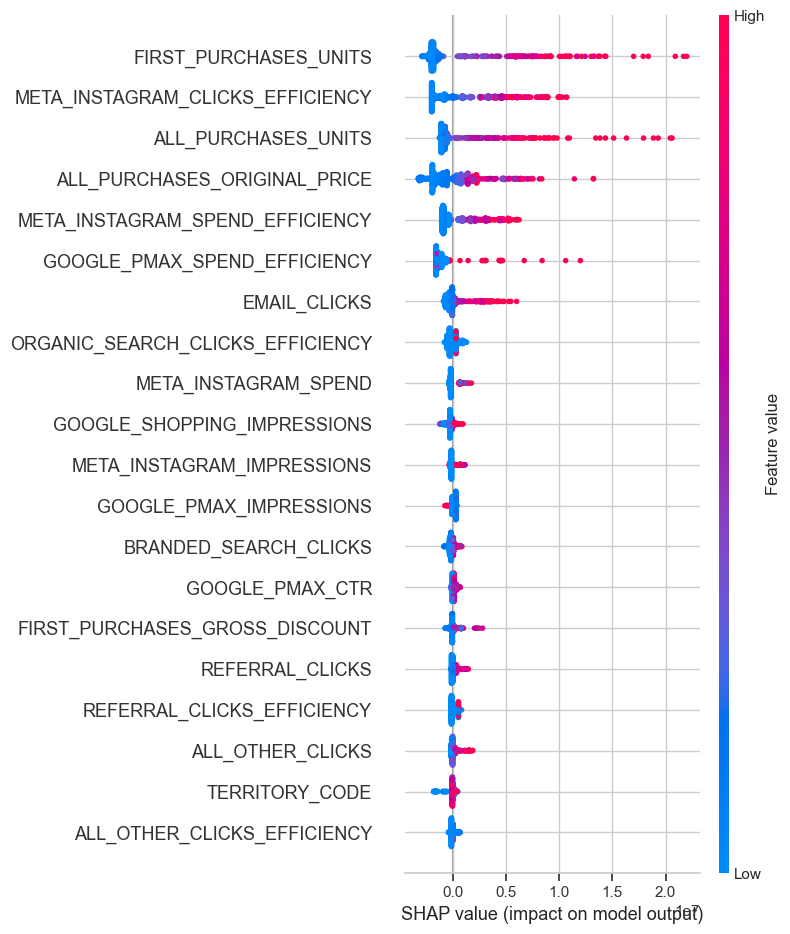

In [1583]:
shap.initjs()

# Ensure you're using the tuned model `best_xgb`
explainer = shap.Explainer(best_xgb, X_train)  # Use the tuned model here
shap_values = explainer(X_test)

# Create the SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=X.columns)


###  ----Wise SHAP Summary: Spend, Click, Impression, and Purchase Features

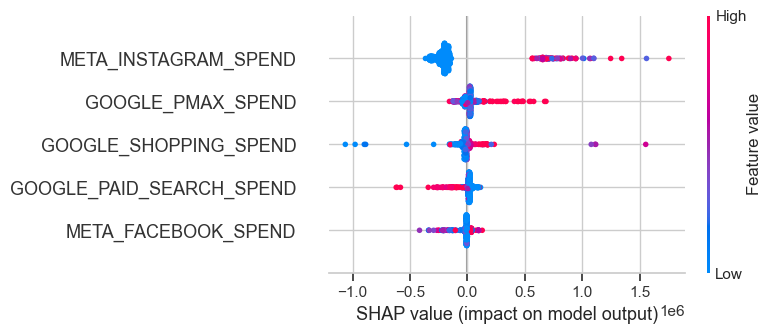

🔍 SHAP Summary for Spend Features



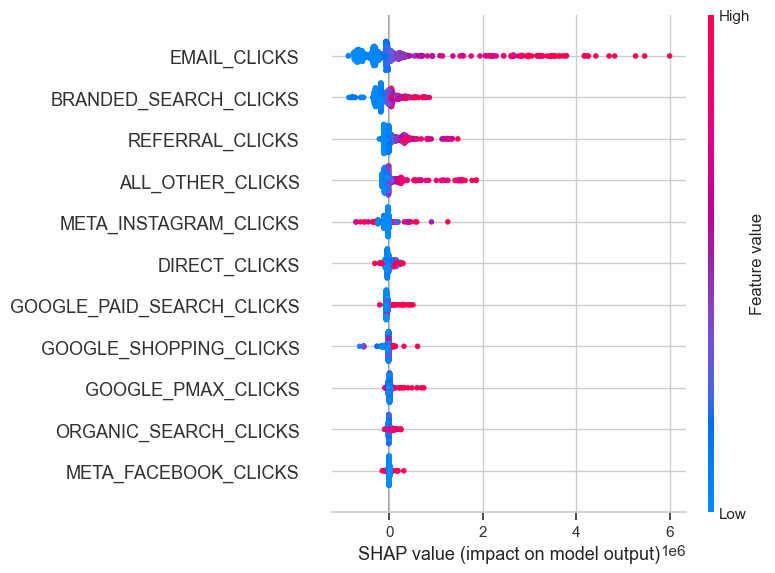

🔍 SHAP Summary for Click Features



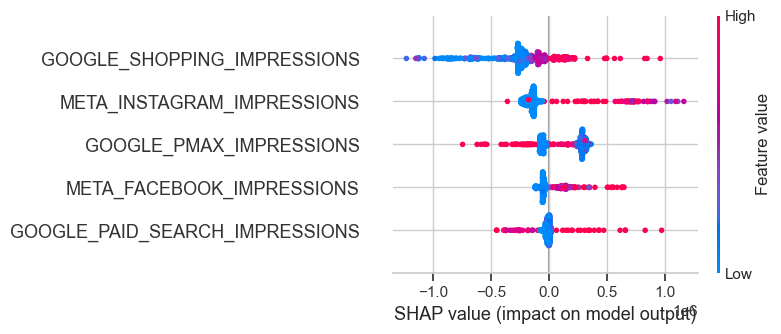

🔍 SHAP Summary for Impression Features



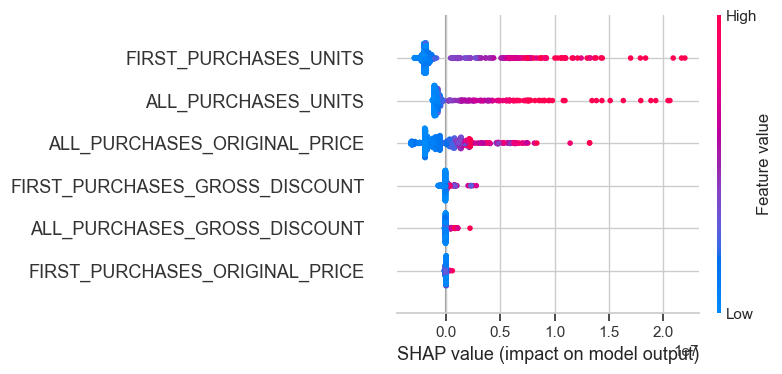

🔍 SHAP Summary for Purchase Features



In [1585]:
shap.initjs()

# Use tuned model
explainer = shap.Explainer(best_xgb, X_train)
shap_values = explainer(X_test)

# Wrap X_test in a DataFrame with original column names
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# SHAP for each category
def shap_group_plot(group_features, label):
    subset = X_test_df[group_features]
    subset_shap_values = shap_values[:, [X.columns.get_loc(c) for c in group_features]]
    shap.summary_plot(subset_shap_values.values, subset, feature_names=group_features, show=True)
    print(f"🔍 SHAP Summary for {label}\n")

# Run SHAP plots for each category
shap_group_plot(spend_cols, "Spend Features")
shap_group_plot(click_cols, "Click Features")
shap_group_plot(impression_cols, "Impression Features")
shap_group_plot(purchase_cols, "Purchase Features")


###  ----  Covers Efficiency Metrics

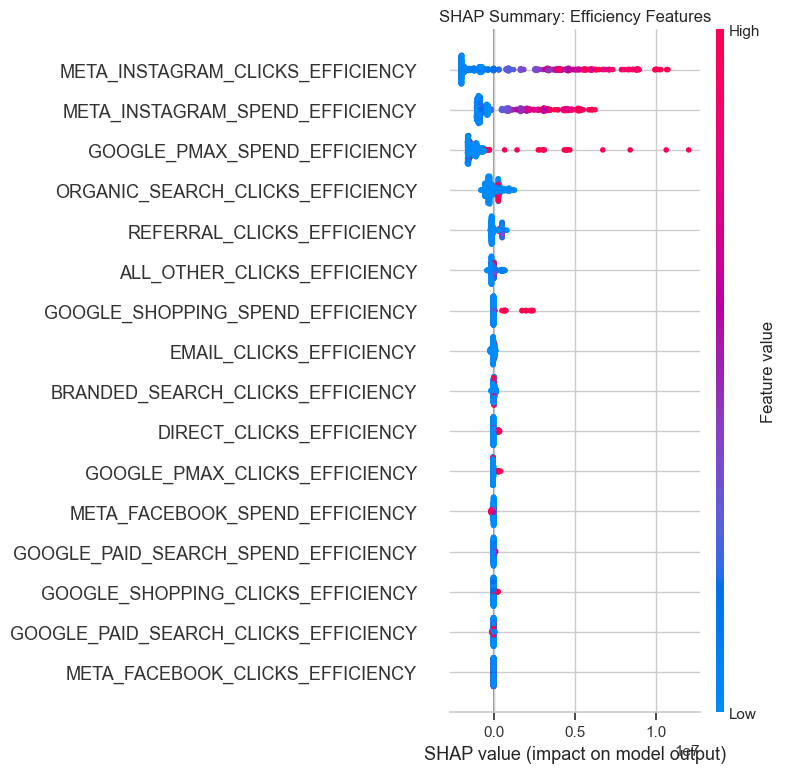

In [1587]:
import shap
import matplotlib.pyplot as plt

# Use tuned XGBoost model and initialize SHAP explainer
explainer = shap.Explainer(best_xgb, X_train)
shap_values = explainer(X_test)

# Identify efficiency columns
efficiency_cols = [col for col in X.columns if 'EFFICIENCY' in col]

# Subset test data to only efficiency columns
efficiency_subset = pd.DataFrame(X_test, columns=X.columns)[efficiency_cols]

# Extract SHAP values for only efficiency columns
efficiency_indices = [X.columns.get_loc(c) for c in efficiency_cols]
efficiency_shap_values = shap_values[:, efficiency_indices]

# Plot SHAP summary
shap.summary_plot(
    efficiency_shap_values.values,
    efficiency_subset,
    feature_names=efficiency_cols,
    show=False
)
plt.title("SHAP Summary: Efficiency Features")
plt.tight_layout()
plt.show()


###  ----- Identify unexplored features

🔍 Unexplored features for SHAP: ['GOOGLE_PAID_SEARCH_CTR', 'GOOGLE_SHOPPING_CTR', 'GOOGLE_PMAX_CTR', 'META_FACEBOOK_CTR', 'META_INSTAGRAM_CTR', 'year', 'month', 'week', 'TERRITORY_CODE']


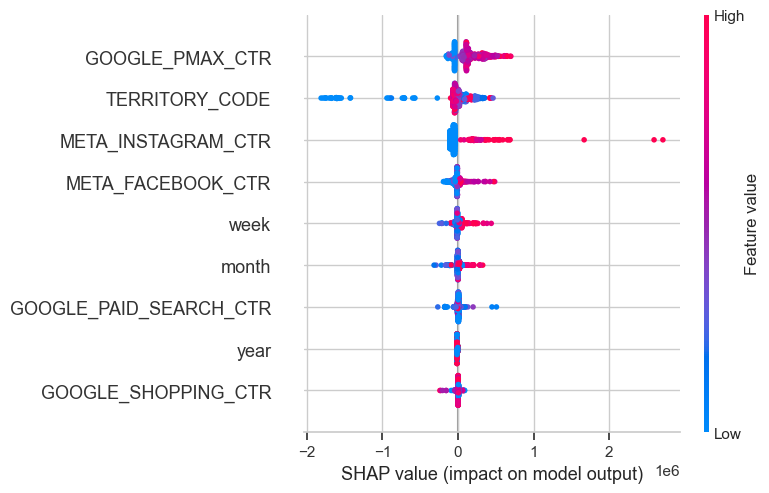

🔍 SHAP Summary for Remaining / Miscellaneous Features



In [1589]:
# Identify unexplored features
used_features = set(spend_cols + click_cols + impression_cols + purchase_cols + efficiency_cols)
remaining_features = [col for col in X.columns if col not in used_features]

print("🔍 Unexplored features for SHAP:", remaining_features)

# Plot SHAP summary for remaining features (if any)
if remaining_features:
    shap_group_plot(remaining_features, "Remaining / Miscellaneous Features")
else:
    print("✅ All features have been included in SHAP analysis.")


### ----  Taking EMAIL_CLICKS which has the highest rating from its SHAP category
### ----  Changing EMAIL_CLICKS by ±10% had no impact on predicted revenue

In [1591]:
# Assume 'weekly_features', 'best_xgb', 'scaler', and 'X.columns' are already defined in your notebook

# Use the first non-zero revenue row as the baseline input
baseline_row_raw = weekly_features[weekly_features['revenue'] > 0].iloc[0].drop(['DATE_DAY', 'TERRITORY_NAME', 'revenue'])
baseline_scaled = pd.Series(scaler.transform([baseline_row_raw])[0], index=X.columns)

# Create variations of ALL_PURCHASES_UNITS
purchase_variants = {
    "Baseline": baseline_scaled.copy(),
    "EMAIL_CLICKS -10%": baseline_scaled.copy(),
    "EMAIL_CLICKS +10%": baseline_scaled.copy()
}

In [1592]:
# Locate index for modification
target_feature = 'EMAIL_CLICKS'
col_idx = X.columns.get_loc(target_feature)

# Modify the feature
purchase_variants["EMAIL_CLICKS -10%"].iloc[col_idx] *= 0.9
purchase_variants["EMAIL_CLICKS +10%"].iloc[col_idx] *= 1.1

In [1593]:
# Predict outcomes
purchase_predictions = {
    label: best_xgb.predict(pd.DataFrame([row], columns=X.columns))[0]
    for label, row in purchase_variants.items()
}

In [1594]:
# Summarize
purchase_df = pd.DataFrame(list(purchase_predictions.items()), columns=["Scenario", "Predicted Revenue"])
purchase_df["Change vs Baseline"] = purchase_df["Predicted Revenue"] - purchase_df["Predicted Revenue"].iloc[0]
purchase_df["% Change"] = purchase_df["Change vs Baseline"] / purchase_df["Predicted Revenue"].iloc[0] * 100

# Display results
print("\n=== Purchase Feature Simulation Results ===\n")
display(purchase_df)


=== Purchase Feature Simulation Results ===



Scenario  Predicted Revenue  Change vs Baseline  % Change
0           Baseline           834123.0                 0.0       0.0
1  EMAIL_CLICKS -10%           834123.0                 0.0       0.0
2  EMAIL_CLICKS +10%           834123.0                 0.0       0.0

##  ------ Simulation of Budget Reallocation Scenarios Using XGBoost Predictions

####  ----  Scaling One Channel Across Levels

In [1597]:
import pandas as pd
import matplotlib.pyplot as plt

# Use the first row of test data as baseline
baseline_row = pd.DataFrame(X_test, columns=X.columns).iloc[0].copy()
spend_features = [col for col in X.columns if '_SPEND' in col]

# -------- Approach 1: Scaling One Channel Across Levels -------- #
def simulate_spend_scaling(channel, levels=[0.5, 1.0, 1.5, 2.0]):
    results = []
    for level in levels:
        row = baseline_row.copy()
        row[channel] *= level
        pred = best_xgb.predict(pd.DataFrame([row]))[0]
        results.append((f"{channel} x{level}", pred))
    return results
    

####  ---- Reallocating Spend Between Channels

In [1599]:
# -------- Approach 2: Reallocating Spend Between Channels -------- #
def simulate_reallocation(from_channels, to_channel, retain_ratio=0.5):
    row = baseline_row.copy()
    reallocation_amt = sum(row[ch] * (1 - retain_ratio) for ch in from_channels)
    for ch in from_channels:
        row[ch] *= retain_ratio
    row[to_channel] += reallocation_amt
    pred = best_xgb.predict(pd.DataFrame([row]))[0]
    return f"Reallocate {' + '.join(from_channels)} → {to_channel}", pred

# Example 2: Shift from Meta to Google Paid Search
reallocation_label, reallocation_pred = simulate_reallocation(
    from_channels=["META_FACEBOOK_SPEND", "META_INSTAGRAM_SPEND"],
    to_channel="GOOGLE_PAID_SEARCH_SPEND"
)

#### ------  Testing Different Channels (Reallocation)

In [1601]:
# -------- Combine and Visualize Results -------- #
comparison_df = pd.DataFrame(scaling_results + [(reallocation_label, reallocation_pred)],
                             columns=["Scenario", "Predicted Revenue"])

# Add baseline revenue for change computation
baseline_revenue = scaling_results[1][1]  # x1.0 is baseline
comparison_df["Change"] = comparison_df["Predicted Revenue"] - baseline_revenue
comparison_df["% Change"] = 100 * comparison_df["Change"] / baseline_revenue

In [1602]:
# Show table
comparison_df.head()

Scenario  Predicted Revenue  \
0                             GOOGLE_PMAX_SPEND x0.5          6544338.0   
1                             GOOGLE_PMAX_SPEND x1.0          6513141.0   
2                             GOOGLE_PMAX_SPEND x1.5          6513141.0   
3                             GOOGLE_PMAX_SPEND x2.0          6513141.0   
4  Reallocate META_FACEBOOK_SPEND + META_INSTAGRA...          7215464.0   

     Change   % Change  
0   31197.0   0.478985  
1       0.0   0.000000  
2       0.0   0.000000  
3       0.0   0.000000  
4  702323.0  10.783170

###  ----Shows the impact of spend scaling vs. Reallocation Using XGBoost Predictions

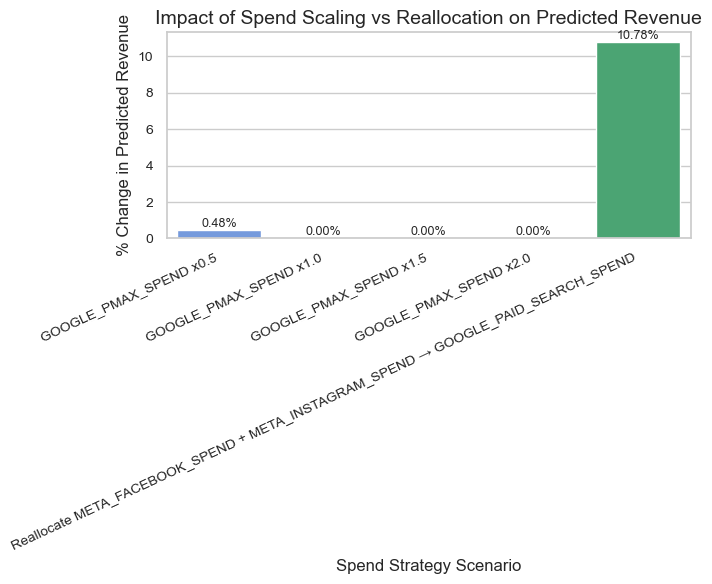

In [1604]:
plt.figure(figsize=(7, 6))

# Assign colors by strategy type
colors = ['cornflowerblue'] * 4 + ['mediumseagreen']

# Plot bars
bars = sns.barplot(x="Scenario", y="% Change", data=comparison_df, palette=colors)

# Annotate bars
for bar in bars.patches:
    height = bar.get_height()
    bars.annotate(f"{height:.2f}%",
                  (bar.get_x() + bar.get_width() / 2, height),
                  ha='center', va='bottom', fontsize=9)

# Style
plt.ylabel("% Change in Predicted Revenue", fontsize=12)
plt.xlabel("Spend Strategy Scenario", fontsize=12)
plt.title("Impact of Spend Scaling vs Reallocation on Predicted Revenue", fontsize=14)
plt.xticks(rotation=25, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

### ----- Budget Reallocation Scenario Simulation Employing XGBoost Predictions 

In [1606]:
# Train model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Get informative non-zero row
non_zero_index = weekly_features[weekly_features['revenue'] > 0].index[0]
baseline_row_raw = weekly_features.loc[non_zero_index].drop(labels=['DATE_DAY', 'TERRITORY_NAME', 'revenue'])
baseline_row_scaled = pd.Series(scaler.transform([baseline_row_raw])[0], index=X.columns)

# Valid spend features
valid_spend_features = [
    'GOOGLE_PAID_SEARCH_SPEND',
    'GOOGLE_SHOPPING_SPEND',
    'GOOGLE_PMAX_SPEND',
    'META_FACEBOOK_SPEND',
    'META_INSTAGRAM_SPEND'
]

# Define scenarios
sim_scenarios = {
    "Baseline": baseline_row_scaled.copy(),
    "Boost META_INSTAGRAM_SPEND by 75%": baseline_row_scaled.copy(),
    "Reallocate META_FACEBOOK → META_INSTAGRAM": baseline_row_scaled.copy(),
    "Cut GOOGLE_PAID_SEARCH_SPEND by 50%": baseline_row_scaled.copy(),
    "Boost All GOOGLE_*_SPEND by 25%": baseline_row_scaled.copy()
}

# Apply changes
sim_scenarios["Boost META_INSTAGRAM_SPEND by 75%"]["META_INSTAGRAM_SPEND"] *= 1.75
transfer_amt = 0.5 * sim_scenarios["Reallocate META_FACEBOOK → META_INSTAGRAM"]["META_FACEBOOK_SPEND"]
sim_scenarios["Reallocate META_FACEBOOK → META_INSTAGRAM"]["META_FACEBOOK_SPEND"] *= 0.5
sim_scenarios["Reallocate META_FACEBOOK → META_INSTAGRAM"]["META_INSTAGRAM_SPEND"] += transfer_amt
sim_scenarios["Cut GOOGLE_PAID_SEARCH_SPEND by 50%"]["GOOGLE_PAID_SEARCH_SPEND"] *= 0.5
google_spend_cols = [col for col in valid_spend_features if "GOOGLE" in col]
for col in google_spend_cols:
    sim_scenarios["Boost All GOOGLE_*_SPEND by 25%"][col] *= 1.25

# Predict
prediction_results = {
    label: xgb_model.predict(pd.DataFrame([row])[X.columns])[0]
    for label, row in sim_scenarios.items()
}

# Summarize
result_df = pd.DataFrame(list(prediction_results.items()), columns=["Scenario", "Predicted Revenue"])
result_df["Change vs Baseline"] = result_df["Predicted Revenue"] - result_df["Predicted Revenue"].iloc[0]
result_df["% Change"] = result_df["Change vs Baseline"] / result_df["Predicted Revenue"].iloc[0] * 100

result_df

Scenario  Predicted Revenue  \
0                                   Baseline        1104505.500   
1          Boost META_INSTAGRAM_SPEND by 75%        1104505.500   
2  Reallocate META_FACEBOOK → META_INSTAGRAM        1034487.625   
3        Cut GOOGLE_PAID_SEARCH_SPEND by 50%        1177831.000   
4            Boost All GOOGLE_*_SPEND by 25%        1104505.500   

   Change vs Baseline  % Change  
0               0.000  0.000000  
1               0.000  0.000000  
2          -70017.875 -6.339296  
3           73325.500  6.638763  
4               0.000  0.000000

###   -----Budget Reallocation Strategies' Effect on Estimated Revenue. 

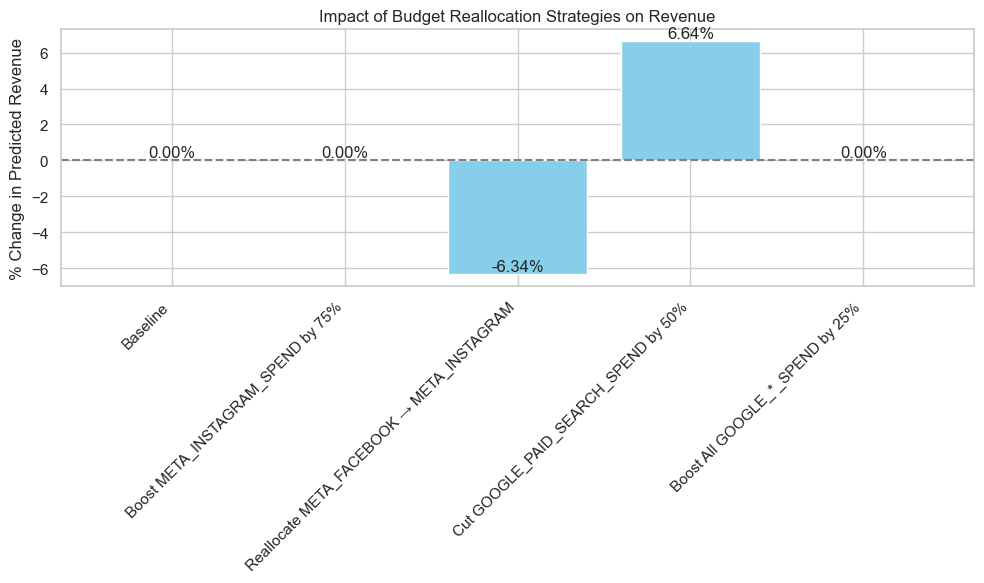

In [1608]:
# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(result_df["Scenario"], result_df["% Change"], color='skyblue')
plt.axhline(0, color='gray', linestyle='--')
plt.ylabel("% Change in Predicted Revenue")
plt.title("Impact of Budget Reallocation Strategies on Revenue")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval, f"{yval:.2f}%", ha='center', va='bottom')

plt.show()


###  ---- Utilizing Scipy's (SLSQP) Minimize as an Optimization Method for Budget 

In [1610]:


# Train the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Optimization Setup
optimization_features = [
    'GOOGLE_PAID_SEARCH_SPEND',
    'GOOGLE_SHOPPING_SPEND',
    'GOOGLE_PMAX_SPEND',
    'META_FACEBOOK_SPEND',
    'META_INSTAGRAM_SPEND'
]

baseline_row_raw = weekly_features[weekly_features['revenue'] > 0].iloc[0].drop(['DATE_DAY', 'TERRITORY_NAME', 'revenue'])
total_budget = baseline_row_raw[optimization_features].sum()
bounds = [(0.5 * baseline_row_raw[feat], 1.5 * baseline_row_raw[feat]) for feat in optimization_features]

def objective(budget_allocation):
    row = baseline_row_raw.copy()
    for i, feat in enumerate(optimization_features):
        row[feat] = budget_allocation[i]
    scaled_input = scaler.transform([row])[0]
    df_input = pd.DataFrame([scaled_input], columns=X.columns)
    predicted_revenue = xgb_model.predict(df_input)[0]
    return -predicted_revenue

constraints = [{
    'type': 'eq',
    'fun': lambda x: np.sum(x) - total_budget
}]

initial_guess = baseline_row_raw[optimization_features].values
result = minimize(
    objective,
    initial_guess,
    bounds=bounds,
    constraints=constraints,
    method='SLSQP'
)

optimized_budget = dict(zip(optimization_features, result.x))
optimized_prediction = -result.fun

# Output results
optimized_df = pd.DataFrame.from_dict(optimized_budget, orient='index', columns=['Optimized Spend'])
optimized_df.loc['Total', 'Optimized Spend'] = np.sum(result.x)
optimized_df.loc['Predicted Revenue', 'Optimized Spend'] = optimized_prediction

optimized_df

Optimized Spend
GOOGLE_PAID_SEARCH_SPEND              0.0
GOOGLE_SHOPPING_SPEND               555.7
GOOGLE_PMAX_SPEND                     0.0
META_FACEBOOK_SPEND                   0.0
META_INSTAGRAM_SPEND                  0.0
Total                               555.7
Predicted Revenue               1104505.5

## ------Optimized vs. Baseline Marketing Spending Across Channels

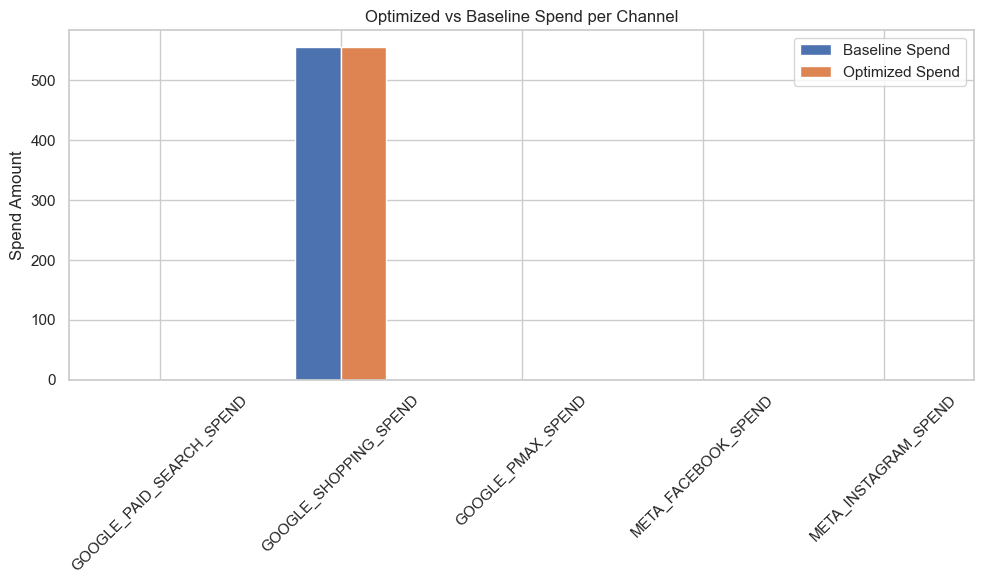

In [1612]:
baseline_row_raw = weekly_features[weekly_features['revenue'] > 0].iloc[0].drop(['DATE_DAY', 'TERRITORY_NAME', 'revenue'])
total_budget = baseline_row_raw[optimization_features].sum()
bounds = [(0.5 * baseline_row_raw[feat], 1.5 * baseline_row_raw[feat]) for feat in optimization_features]

def objective(budget_allocation):
    row = baseline_row_raw.copy()
    for i, feat in enumerate(optimization_features):
        row[feat] = budget_allocation[i]
    scaled_input = scaler.transform([row])[0]
    df_input = pd.DataFrame([scaled_input], columns=X.columns)
    predicted_revenue = xgb_model.predict(df_input)[0]
    return -predicted_revenue

constraints = [{
    'type': 'eq',
    'fun': lambda x: np.sum(x) - total_budget
}]
initial_guess = baseline_row_raw[optimization_features].values
result = minimize(objective, initial_guess, bounds=bounds, constraints=constraints, method='SLSQP')

# Optimized output
optimized_budget = dict(zip(optimization_features, result.x))
optimized_prediction = -result.fun

# Visualization: Optimized vs Baseline
baseline_spend = baseline_row_raw[optimization_features].copy()
optimized_spend = pd.Series(result.x, index=optimization_features)
spend_comparison = pd.DataFrame({
    'Baseline Spend': baseline_spend,
    'Optimized Spend': optimized_spend
})
spend_comparison.plot(kind='bar', figsize=(10, 6))
plt.title("Optimized vs Baseline Spend per Channel")
plt.ylabel("Spend Amount")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### --- Mean SHAP Value Plot for Top Predictive Features Influencing Revenue

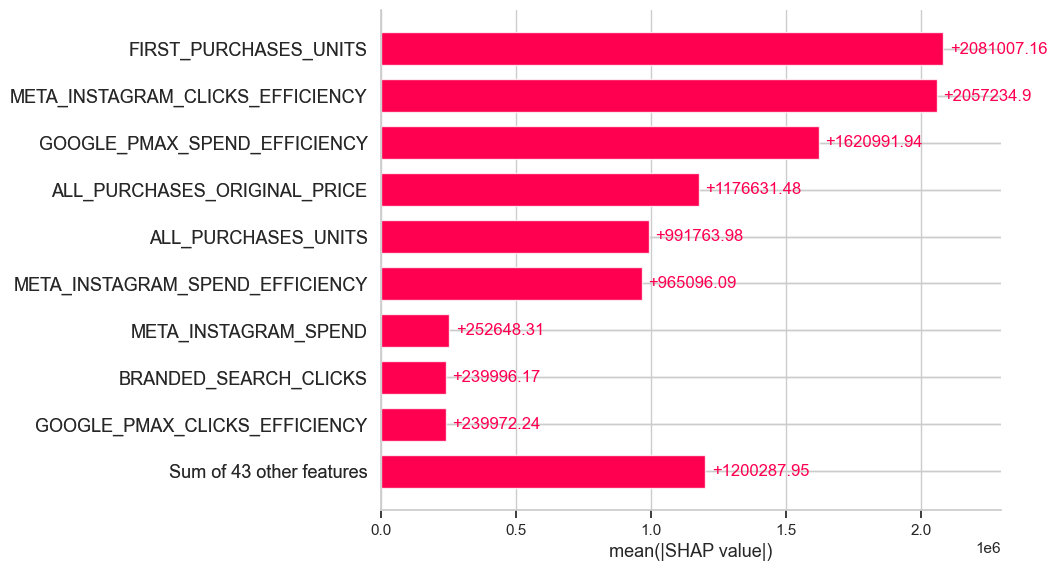

In [1614]:
baseline_row_raw = weekly_features[weekly_features['revenue'] > 0].iloc[0].drop(['DATE_DAY', 'TERRITORY_NAME', 'revenue'])
total_budget = baseline_row_raw[optimization_features].sum()
bounds = [(0.5 * baseline_row_raw[feat], 1.5 * baseline_row_raw[feat]) for feat in optimization_features]

def objective(budget_allocation):
    row = baseline_row_raw.copy()
    for i, feat in enumerate(optimization_features):
        row[feat] = budget_allocation[i]
    scaled_input = scaler.transform([row])[0]
    df_input = pd.DataFrame([scaled_input], columns=X.columns)
    predicted_revenue = xgb_model.predict(df_input)[0]
    return -predicted_revenue

constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - total_budget}]
initial_guess = baseline_row_raw[optimization_features].values
result = minimize(objective, initial_guess, bounds=bounds, constraints=constraints, method='SLSQP')

# Recreate optimized row
optimized_budget = dict(zip(optimization_features, result.x))
optimized_row_full = baseline_row_raw.copy()
for feat, val in optimized_budget.items():
    optimized_row_full[feat] = val
optimized_row_scaled = scaler.transform([optimized_row_full])[0]

# Run SHAP
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(pd.DataFrame([optimized_row_scaled], columns=X.columns))

# Plot SHAP summary
shap.plots.bar(shap_values)


# -------- Classification high vs Low Revenue)


--- XGBoost ---
XGBoost Accuracy: 0.972875226039783
XGBoost Confusion Matrix:
 [[409   6]
 [  9 129]]
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       415
           1       0.96      0.93      0.95       138

    accuracy                           0.97       553
   macro avg       0.97      0.96      0.96       553
weighted avg       0.97      0.97      0.97       553



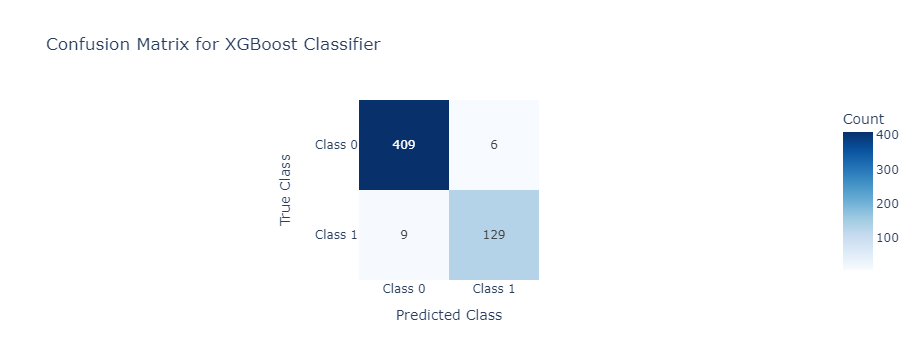


--- Random Forest ---
Random Forest Accuracy: 0.9584086799276673
Random Forest Confusion Matrix:
 [[403  12]
 [ 11 127]]
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       415
           1       0.91      0.92      0.92       138

    accuracy                           0.96       553
   macro avg       0.94      0.95      0.94       553
weighted avg       0.96      0.96      0.96       553



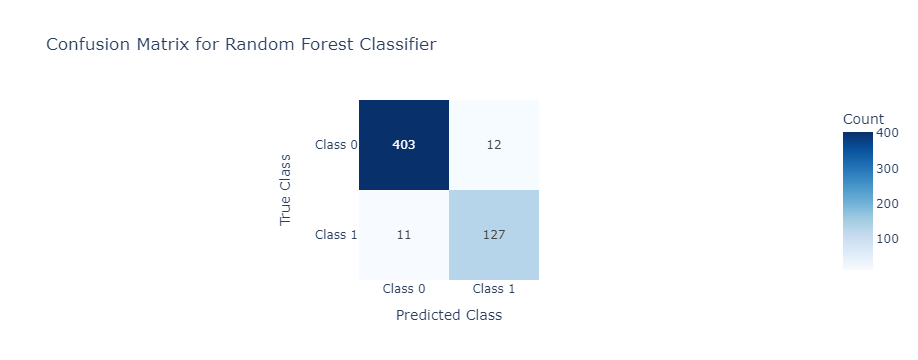


--- KNN ---
KNN Accuracy: 0.9367088607594937
KNN Confusion Matrix:
 [[403  12]
 [ 23 115]]
KNN Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       415
           1       0.91      0.83      0.87       138

    accuracy                           0.94       553
   macro avg       0.93      0.90      0.91       553
weighted avg       0.94      0.94      0.94       553



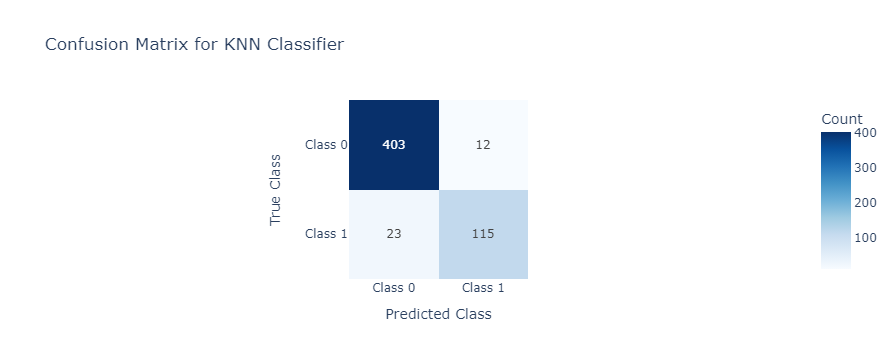


--- Gradient Boosting ---
Gradient Boosting Accuracy: 0.9566003616636528
Gradient Boosting Confusion Matrix:
 [[403  12]
 [ 12 126]]
Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       415
           1       0.91      0.91      0.91       138

    accuracy                           0.96       553
   macro avg       0.94      0.94      0.94       553
weighted avg       0.96      0.96      0.96       553



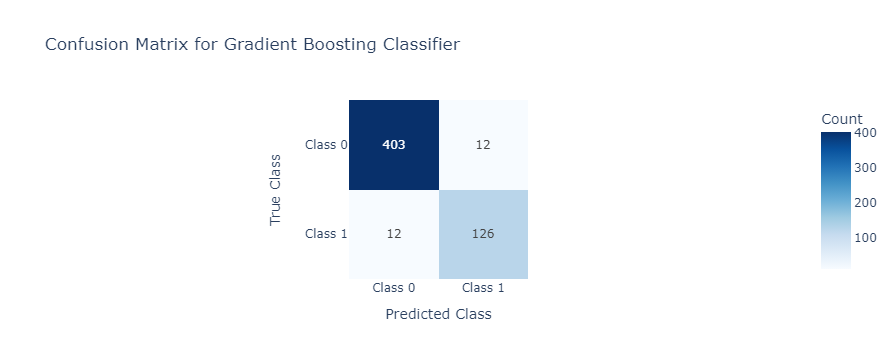


--- Ridge Classifier ---
Ridge Classifier Accuracy: 0.9439421338155516
Ridge Classifier Confusion Matrix:
 [[407   8]
 [ 23 115]]
Ridge Classifier Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96       415
           1       0.93      0.83      0.88       138

    accuracy                           0.94       553
   macro avg       0.94      0.91      0.92       553
weighted avg       0.94      0.94      0.94       553



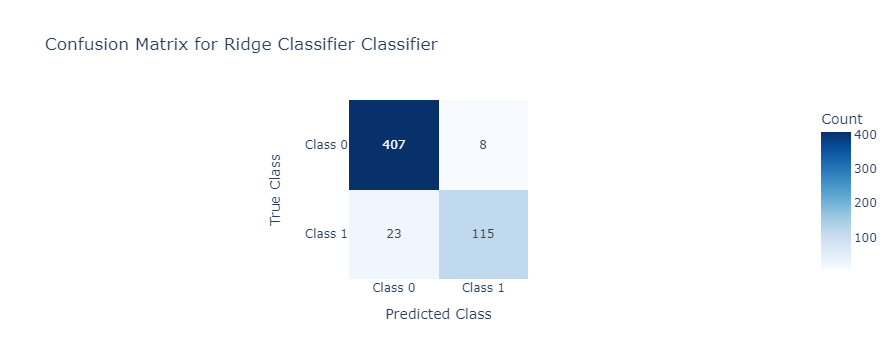


--- Logistic Regression ---
Logistic Regression Accuracy: 0.9547920433996383
Logistic Regression Confusion Matrix:
 [[404  11]
 [ 14 124]]
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       415
           1       0.92      0.90      0.91       138

    accuracy                           0.95       553
   macro avg       0.94      0.94      0.94       553
weighted avg       0.95      0.95      0.95       553



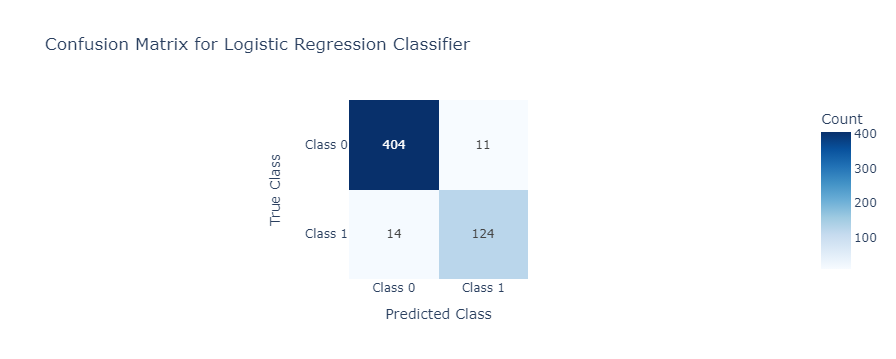


--- Decision Tree ---
Decision Tree Accuracy: 0.9439421338155516
Decision Tree Confusion Matrix:
 [[395  20]
 [ 11 127]]
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96       415
           1       0.86      0.92      0.89       138

    accuracy                           0.94       553
   macro avg       0.92      0.94      0.93       553
weighted avg       0.95      0.94      0.94       553



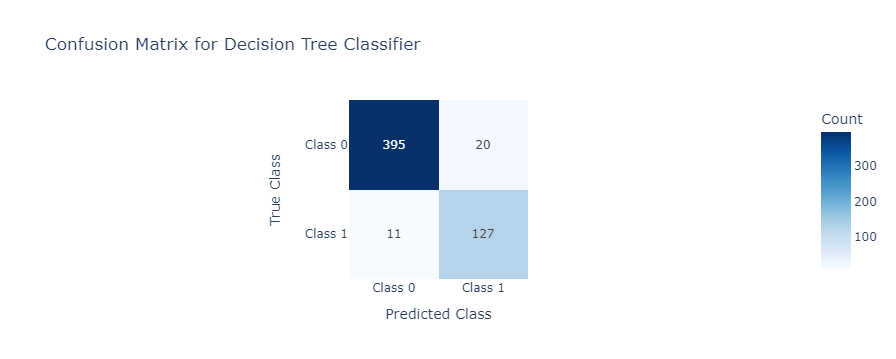

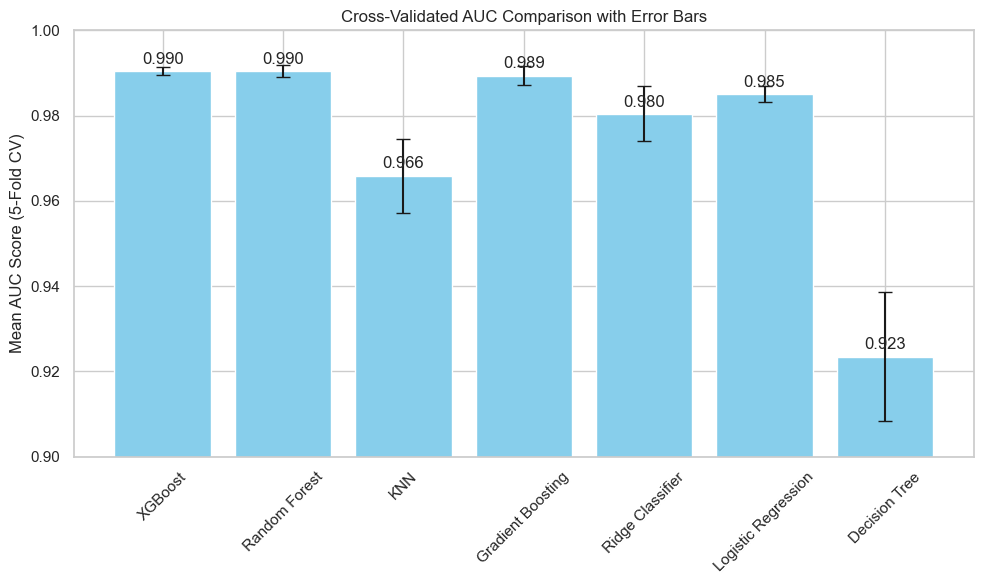

In [1616]:
# ----------------------- Classification Setup (For `weekly_features`) -----------------------
# Define high revenue threshold for binary classification
revenue_threshold = weekly_features['revenue'].quantile(0.75)
weekly_features['high_revenue_class'] = (weekly_features['revenue'] > revenue_threshold).astype(int)

# Prepare features
exclude_columns = ['DATE_DAY', 'TERRITORY_NAME', 'revenue', 'high_revenue_class', 'CURRENCY_CODE']
exclude_keywords = ['_CTR', '_EFFICIENCY']
X = weekly_features.drop(columns=[col for col in weekly_features.columns if col in exclude_columns or any(kw in col for kw in exclude_keywords)])
y = weekly_features['high_revenue_class']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define parameter grids for tuning
param_grids = {
    "XGBoost": {
        'n_estimators': [100, 150],
        'max_depth': [3, 5],
        'learning_rate': [0.1, 0.05]
    },
    "Random Forest": {
        'n_estimators': [100, 150],
        'max_depth': [10, 15],
        'min_samples_split': [2, 5]
    },
    "KNN": {
        'n_neighbors': [3, 5, 7]
    },
    "Gradient Boosting": {
        'n_estimators': [100, 150],
        'learning_rate': [0.1, 0.05],
        'max_depth': [3, 5]
    },
    "Ridge Classifier": {},
    "Logistic Regression": {
        'C': [0.1, 1.0, 10.0]
    },
    "Decision Tree": {
        'max_depth': [10, 20],
        'min_samples_split': [2, 5]
    }
}

# Train, tune, and evaluate each model
models = {
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Ridge Classifier": RidgeClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

auc_scores = {}
roc_results = {}

for name, model in models.items():
    print(f"\n--- {name} ---")
    grid = GridSearchCV(model, param_grids[name], cv=5, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train_scaled, y_train)
    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test_scaled)
    print(f"{name} Accuracy:", accuracy_score(y_test, y_pred))
    print(f"{name} Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print(f"{name} Classification Report:\n", classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    fig = px.imshow(cm, text_auto=True, color_continuous_scale='Blues',
                    title=f"Confusion Matrix for {name} Classifier",
                    labels=dict(x="Predicted Class", y="True Class", color="Count"))
    fig.update_layout(xaxis=dict(tickmode="array", tickvals=[0, 1], ticktext=["Class 0", "Class 1"]),
                      yaxis=dict(tickmode="array", tickvals=[0, 1], ticktext=["Class 0", "Class 1"]))
    fig.show()
    
   # Cross-validation AUC
    cv_auc = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
    auc_scores[name] = (cv_auc.mean(), cv_auc.std())

    # ROC for test set
    if hasattr(best_model, "predict_proba"):
        y_score = best_model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_score = best_model.decision_function(X_test_scaled)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_results[name] = (fpr, tpr, roc_auc_score(y_test, y_score))

# AUC Bar Plot
plt.figure(figsize=(10, 6))
models_list = list(auc_scores.keys())
means = [auc_scores[m][0] for m in models_list]
stds = [auc_scores[m][1] for m in models_list]

bars = plt.bar(models_list, means, yerr=stds, capsize=5, color='skyblue')
plt.ylim(0.9, 1.0)
plt.title("Cross-Validated AUC Comparison with Error Bars")
plt.ylabel("Mean AUC Score (5-Fold CV)")
plt.xticks(rotation=45)
plt.grid(True, axis='y')

for bar, mean in zip(bars, means):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.001, f"{mean:.3f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

# -------- Comparing ROC Curves for Different Models

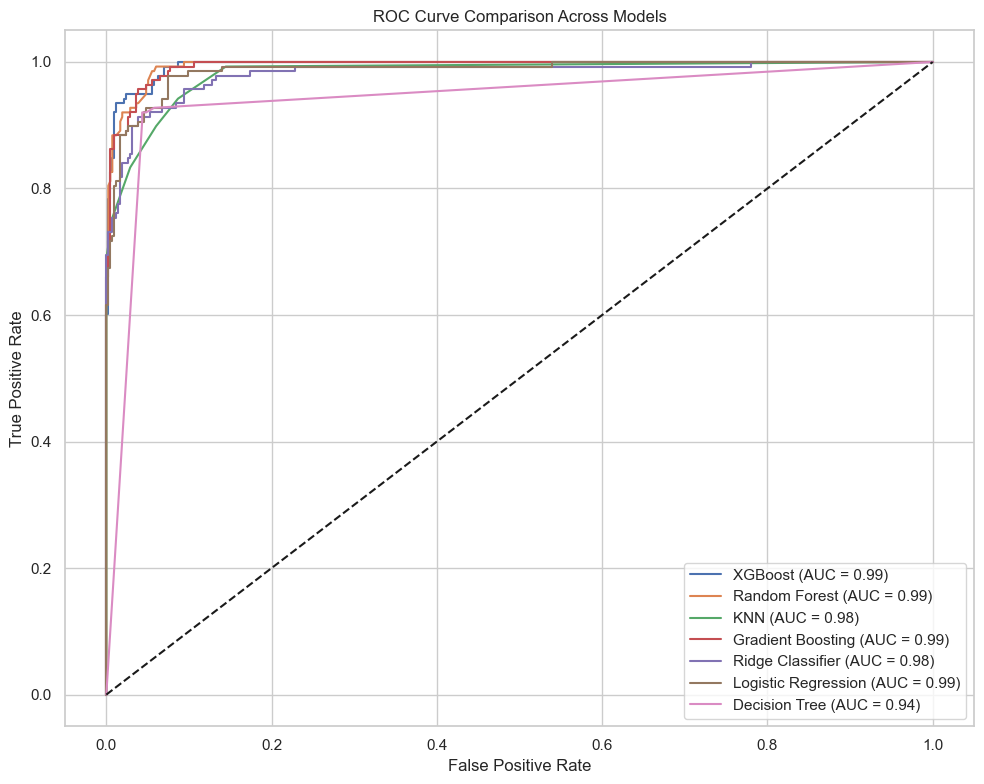

In [1618]:
# ROC Curves for all models
plt.figure(figsize=(10, 8))
for model_name, (fpr, tpr, auc_val) in roc_results.items():
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_val:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Comparison Across Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


# ---- SARIMA Revenue Forecast (102 Weeks Ahead) same as 2 years

SARIMA RMSE: 77,219,318.16


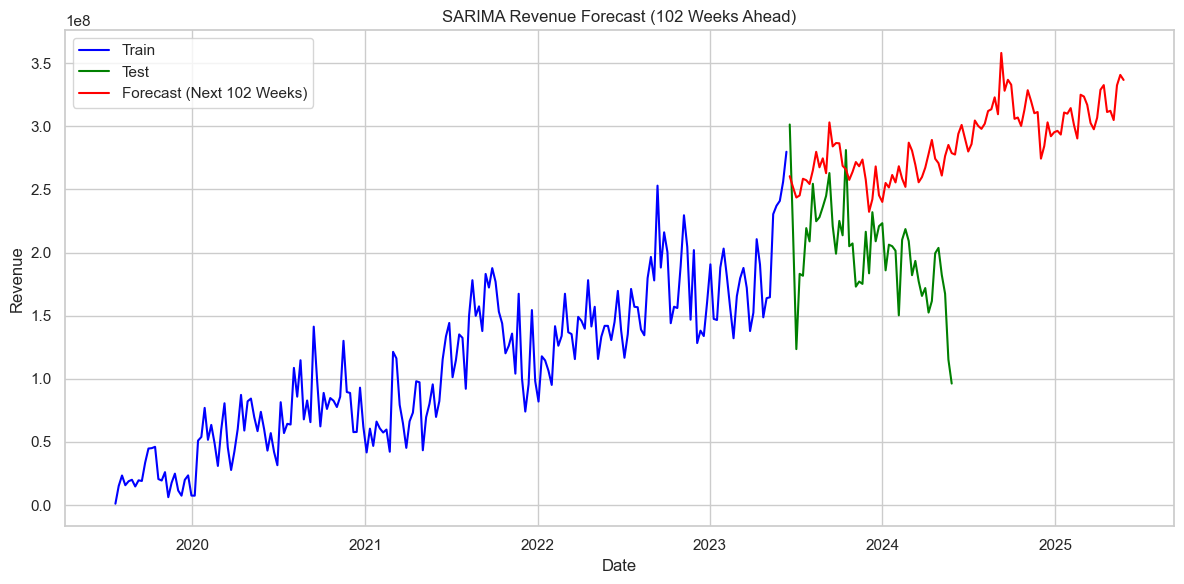

In [1620]:
# STEP 1: Drop 'high_revenue_class' if it exists
weekly_df = weekly_features.drop(columns=['high_revenue_class'], errors='ignore')

# STEP 2: Aggregate revenue by week to ensure unique timestamps
weekly_revenue = (
    weekly_df[['DATE_DAY', 'revenue']]
    .copy()
    .set_index('DATE_DAY')
    .resample('W')        # Weekly resampling
    .sum()
)

# STEP 3: Ensure proper datetime index with frequency
weekly_revenue.index = pd.DatetimeIndex(weekly_revenue.index).to_period("W").to_timestamp()

# STEP 4: Train-Test Split (last 50 weeks for testing)
train = weekly_revenue.iloc[:-50]
test = weekly_revenue.iloc[-50:]

# STEP 5: Fit SARIMA model
model = SARIMAX(train['revenue'],
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 52),
                enforce_stationarity=False,
                enforce_invertibility=False)
sarima_results = model.fit(disp=False)

# STEP 6: Forecast next 102 weeks
forecast = sarima_results.forecast(steps=102)

# STEP 7: Evaluate on the first 50 steps (which align with test)
forecast_for_test = forecast[:len(test)]
rmse = np.sqrt(mean_squared_error(test['revenue'], forecast_for_test))
print(f"SARIMA RMSE: {rmse:,.2f}")

# STEP 8: Plot results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['revenue'], label='Train', color='blue')
plt.plot(test.index, test['revenue'], label='Test', color='green')
plt.plot(forecast.index, forecast, label='Forecast (Next 102 Weeks)', color='red')
plt.title("SARIMA Revenue Forecast (102 Weeks Ahead)")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
